# Model implementation for all the set of subjects

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

## Importing custom functions from different folder:

In [2]:
# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    from utils_data_multiple import load_multiple_data, plot_multiple_data, point_to_segment, cleaning_clustering_multiple_data
    from utils_data_multiple import plot_data
    from utils_data_multiple import saving_processed_mult_data, load_processed_mult_data, multiple_linear_transf  
    
    from utils_data_multiple import get_cluster_data, get_cluster_idxrule
    from utils_model_multiple import numericalSimulation, plot_trajectory
    
    from utils_model_multiple import load_params, fitParamaters_mult
    from utils_model_multiple import plotting_dict_params, combined_multiple_trajectories_plot
    
    
    from utils_model_multiple import dict_to_array
    from utils_model import plot_multiple_trajectories_combined
    #from utils_data import plot_velocity
    #from utils_model_multiple import numericalSimulation, ComputeFunctional, ComputeVel
    #from utils_model_multiple import generate_trajectory, plot_simulation, generate_trajectory_vel, optimize_Sigma, plot_multiple_trajectories, plotting_params
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


## Treating multiple subjects data

Motivation may be: 
- 0: playing alone
- 1: easy rival
- 2: hard rival 

The data is now clustered by motivation level, i.e. `dataTrajecetories-25-M1-C1`. We are also splitting the dataset depending on the playing modes: passing through and stopping. For each dataset moreover we have the four different trajectories.

The data is normalized, clustered in terms of motivation, playing mode and ordered by trajectory. 

We seek to find a paramater fitting for each subject, motivational state and playing mode, and trajectory. Then we can consider the mean for each case to fit the model for each subject and motivational state. 

We consider the mass to be the same at the begining of the movement, hence we are studying 3 motivational states x 2 playing modes parameters per player. 

We have 4 possible trajectories (the playing modes just modify the control function, since the effort is different). 

## Reproducing results

We can reproduce our results in this Notebook by setting the initial parameters as well as on the `main_multiple.py` file. 

Set the following parameters according to the study you wish to conduct: 
- `processing` when set to `True` it conducts the whole processing process from the raw data. This includes: 
    - `cleaning_clustering_multiple_data`: 
        - Cleaning the trajectories which do not cross the target and truncating the ones which do cross it. Also storing the optimal time in which they reach the target, $T^*$, stored in `idxrule` 
        - Classifying the data in 4 clusters, depending on the target they cross
    - `multiple_linear_transf`: 
        - Rotating the needed trajectories and scaling them in order to get normalized data
        - Computing the mean velocity and the velocity profiles for each trajectory

ATTENTION: This process takes more than 2 hours to be fully completed. 

- `fitting` when set to `True` the fitting of the parameters is conducted with the already processed data. This includes: 
    - `fitParamaters_mult`: 
        - Sequential approach: 
            1. Optimal movement duration: Generate the optimal trajectory by optimizing the Functional in terms of the time T 
            2. Optimal controller: generate the optimal trajectory with the optimal time duration by minimizing the functional in terms of the biomechanical parameters $(\alpha, \gamma, \varepsilon)$. 
            3. Stochastic optimization: generate the optimal trajectory with optimal time duration and biomechanical parameters by optimizing the Kolmogorov Sirnov estimate in terms of the sigma 
        - Saving the obtained parameters

- `plotting` when set to `True` all the trajectory plots and prints are explicitly shown on this Notebook
- `saving` when set to `True` all the plots and data processed is saved. 

In [3]:
processing = False
fitting = False
plotting = False
saving = False

### Loading data: 

In [4]:
cluster_points = [
        (10.5, 4.85),   # pt2
        (-11, -5),       # pt3  
        (10.5, 0),      # pt1    
        (-10.5, 1.25)  # pt0
    ]
n_clusters = 4

segments = point_to_segment(cluster_points, n_clusters)

In [5]:
if processing:
    print('Loading and processing data...')
    data_dict = load_multiple_data(first_subj = 25, last_subj = 37, 
                       file_names = 'dataTrajectories' )
    if plotting: 
        print('List with al the target segments:', segments)
        print('List with the two points of segment for cluster 0:', segments[0])
        print('Array with point target 1 for cluster 0:', segments[0][0])
        print('First coordinate of point target 1 for cluster 0:', segments[0][0][0])
        plot_multiple_data(data_dict)
    
    cleaned_data_dict, idxrule_dict = cleaning_clustering_multiple_data(data_dict, 
                                    segments, 
                                    first_subj = 25, last_subj = 37,
                                    save_dir = 'subject_plots')

    if saving: 
        saving_processed_mult_data(idxrule_dict=idxrule_dict, folder_name='clustered_multiple_data')
        saving_processed_mult_data(cleaned_data_dict = cleaned_data_dict, 
                                folder_name = 'clustered_multiple_data')
        
    scaled_data_dict, velocity_dict, results_dict = multiple_linear_transf(cleaned_data_dict, idxrule_dict, 
                            segments, 
                            first_subj = 25, last_subj = 37,
                            n_clusters = 4,
                            saving = True, 
                            save_dir = 'subject_plots_2')
    if saving: 
        saving_processed_mult_data(cleaned_data_dict = scaled_data_dict, 
                                folder_name = 'scaled_data')
        saving_processed_mult_data(cleaned_data_dict = velocity_dict, 
                                folder_name = 'velocity')
        saving_processed_mult_data(idxrule_dict = results_dict, 
                                folder_name = 'scaled_data')
        
    print('Fitting paramaters for the optimized trajectory...')   
    
    if fitting: 
        new_params, opt_sigma = fitParamaters_mult(scaled_data_dict,
                    idxrule_dict, 
                    results_dict,
                    segments, 
                    first_subj = 25, last_subj = 30,
                    n_clusters = 4, folder_name = 'fitted_trajectories_2', 
                    saving = saving)
    
elif fitting: 
    print('Loading processed data...')
    cleaned_data_dict, idxrule_dict = load_processed_mult_data(folder_name='clustered_multiple_data')
    scaled_data_dict, results_dict = load_processed_mult_data(folder_name='scaled_multiple_data') 
    print('Data loaded and processed :)')
    
    print('Fitting paramaters for the optimized trajectory...')   
    new_params, opt_sigma = fitParamaters_mult(scaled_data_dict,
                  idxrule_dict, 
                  results_dict,
                  segments, 
                  first_subj = 25, last_subj = 30,
                  n_clusters = 4, folder_name = 'fitted_trajectories_2', 
                  saving = saving)
    
else: 
    print('Loading fitted parameters...')
    params_loaded = load_params(folder_name = 'fitted_parameters')
    opt_sigma = load_params(folder_name = 'fitted_parameters_sigma')

Loading fitted parameters...
Loading the new parameters...
New parameters have been loaded successfully.
Loading the new parameters...
New parameters have been loaded successfully.


### Plotting trajectories

In [6]:
scaled_data_dict, results_dict = load_processed_mult_data(folder_name='scaled_multiple_data')  

Loading the cleaned data...
CSV and idxrule JSON files have been loaded successfully.


In [7]:
cleaned_data_dict, idxrule_dict = load_processed_mult_data(folder_name='clustered_multiple_data')
    

Loading the cleaned data...
CSV and idxrule JSON files have been loaded successfully.


In [39]:
combined_multiple_trajectories_plot(scaled_data_dict = cleaned_data_dict, 
                                    params_loaded = params_loaded, 
                                    opt_sigma = opt_sigma, 
                                    segments = segments,
                                    first_subj = 25, last_subj = 37,
                                    n_clusters = 4,
                                    saving = True, 
                                    inverse = True, 
                                    save_dir = 'subject_plots', 
                                    picname = 'Simulated_trajectories')

Simulated and experimental trajectories for subject  25
Simulated and experimental trajectories for subject  26
Simulated and experimental trajectories for subject  27
Simulated and experimental trajectories for subject  28
Simulated and experimental trajectories for subject  29
Simulated and experimental trajectories for subject  30
Simulated and experimental trajectories for subject  31
Simulated and experimental trajectories for subject  32
Simulated and experimental trajectories for subject  33
Simulated and experimental trajectories for subject  34
Simulated and experimental trajectories for subject  35
Simulated and experimental trajectories for subject  36


In [27]:
from typing import Tuple, List, Dict
import math

def linear_transf_(dfx : pd.DataFrame, dfy : pd.DataFrame, 
                  rectx : np.ndarray, recty : np.ndarray, 
                  inverse = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    
    if inverse:
        
        if rectx[0] > 0 and recty[-1] > 0:
            model_origin = np.array((0.5,0.2))
            screen_origin = np.array(((rectx[1]+rectx[0])/2,(recty[1]+recty[0])/2))
            model_target = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 

        elif rectx[0] < 0 and recty[-1] > 0: 
            model_origin = np.array((0.8,-0.8))
            screen_origin = np.array(((-rectx[1]-rectx[0])/2,(recty[1]+recty[0])/2))
            model_target = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
            
        elif rectx[0] > 0 and recty[-1] < 0:
            model_origin = np.array((0.9,-0.8))
            screen_origin = np.array(((rectx[1]+rectx[0])/2,(-recty[1]-recty[0])/2)) 
            model_target = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
            
        else: 
            model_origin = np.array((0.5,0.2))
            screen_origin = np.array(((-rectx[1]-rectx[0])/2,(-recty[1]-recty[0])/2))
            model_target = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
    
        screen_target = np.array((0,0)) 
        
    else:
    
        if rectx[0] > 0 and recty[-1] > 0:
            model_target = np.array((0.5,1))
            screen_target = np.array(((rectx[1]+rectx[0])/2,(recty[1]+recty[0])/2))
            model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 

        elif rectx[0] < 0 and recty[-1] > 0: 
            model_target = np.array((1.5,0))
            dfx = -1 * dfx
            screen_target = np.array(((-rectx[1]-rectx[0])/2,(recty[1]+recty[0])/2))
            model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
            
        elif rectx[0] > 0 and recty[-1] < 0:
            model_target = np.array((1.5,0))
            screen_target = np.array(((rectx[1]+rectx[0])/2,(-recty[1]-recty[0])/2)) 
            model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
            
        else: 
            model_target = np.array((0.5,1))
            screen_target = np.array(((-rectx[1]-rectx[0])/2,(-recty[1]-recty[0])/2))
            model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
    
        screen_origin = np.array((0,0))

    v_model=model_target-model_origin
    v_model_ort=np.array((v_model[1],-v_model[0]))

    v_screen=screen_target-screen_origin
    v_screen_ort=np.array((v_screen[1],-v_screen[0]))

    model_M=np.vstack((np.append(model_origin,1),np.append(model_target,1),np.append(v_model_ort,0))).T
    screen_M=np.vstack((np.append(screen_origin,1),np.append(screen_target,1),np.append(v_screen_ort,0))).T

    M=np.dot(model_M,np.linalg.inv(screen_M))
    A=M[:2,:2]
    b=M[:2,-1:].flatten()
    
    if inverse: 
        # Compute the inverse of the affine transformation
        A= np.linalg.inv(A)
        b = -np.dot(A, b)
    
    dfx_=A[0,0]*dfx+A[0,1]*dfy+b[0]
    dfy_=A[1,0]*dfx+A[1,1]*dfy+b[1]
    
    if inverse: 
        if rectx[0] > 0 and recty[-1] > 0:
            return dfx_, dfy_
        elif rectx[0] < 0 and recty[-1] > 0: 
            dfx_ = -1 * dfx_
            return dfx_, dfy_
        elif rectx[0] > 0 and recty[-1] < 0:
            dfy_ = -1 * dfy_
            return dfx_, dfy_
        else: 
            dfx_ = -1 * dfx_
            dfy_ = -1 * dfy_
            return dfx_, dfy_
    
    else: 
        return dfx_, dfy_

In [62]:
def plot_multiple_trajectories(dfx: pd.DataFrame, dfy: pd.DataFrame,
                               new_params: np.ndarray, opt_Sigma: np.float64,  
                               motivation: int, mode : int, cluster : int,
                               segments : List[Tuple[Tuple[float, float], Tuple[float, float]]],
                               parameters2=(3.7, -0.15679707,  0.97252444,  0.54660283, -6.75775885, -0.06253371),
                               n=50, timestep=1/500, pic_name ='Simulated_Trajectories', 
                               folder_name = 'project_plots',
                               ax=None, saving_plot=False, color = 'blue', inverse = False, 
                               metrics = False): 
    
    if ax is None:
        fig, ax = plt.subplots()
    
    if metrics: 
        metrics_results = {}
        
    ## Plotting experimental data
    for i in range(len(dfx)):
        ax.plot(dfx.iloc[i], dfy.iloc[i], color='gray', alpha=0.5, label='Experimental Trajectories' if i == 0 and cluster == 0 else "")
       
                        
    ## Plotting numerical simulation
    gamma, epsilon, alpha = new_params.x
    sigma = opt_Sigma.x
    
    simulated_x = []
    simulated_y = []
    
    for i in range(n):
        x, y, v, w, ux, uy, T = numericalSimulation(x_0=(0,0,0,0), p_T=1.3, 
                                                     sigma=sigma*0.05, gamma=gamma, epsilon=epsilon, alpha=alpha,
                                                     u_0=parameters2[:2], l_0=parameters2[2:], 
                                                     i_max=1000, dt=timestep,
                                                     Autoregr=False, 
                                                     Arc=True, angle=math.pi*12/24, angle0=0, p=(.2,0), r=.1)
        if inverse: 
            x, y = linear_transf_(x, y, segments[cluster][0], segments[cluster][1], inverse = True)
            ax.plot(x, y, color = color, label=f'Simulated Trajectories Cluster {cluster}' if i == 0 else "") 
        else:
            ax.plot(x, y, color = color, label=f'Simulated Trajectories Cluster {cluster}' if i == 0 else "") 
        simulated_x.append(x)
        simulated_y.append(y)
                
    
    if metrics: 
        simulated_x = pad_trajectories(simulated_x)
        simulated_y = pad_trajectories(simulated_y)

        dfx_padded = pad_or_truncate_trajectories(dfx.values, simulated_x.shape[1])
        dfy_padded = pad_or_truncate_trajectories(dfy.values, simulated_y.shape[1])
        
        metrics = ['MSE', 'RMSE', 'DTW', 'MAE']
        metrics_res = []
        for metric in metrics:
            mse_avg_x, mse_avg_y = compute_mse_between_averages(dfx_padded, dfy_padded, simulated_x, simulated_y, error = metric)
        
            #metrics_res.append({metric : (mse_avg_x, mse_avg_y)})
            metrics_res.append((mse_avg_x, mse_avg_y))
        
        metrics_results[cluster] = metrics_res
    
    ax.set_title(f'Motivation {motivation}, Mode {mode}')
    #ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.legend()
    
    if saving_plot:
        # Check if the 'pics' folder exists, if not, create it
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}{motivation}{mode}.png'
        filepath = os.path.join(folder_name, filename)
        plt.savefig(filepath)
    
    if ax is None:
        plt.show()
        
    if metrics:
        return pd.DataFrame(metrics_results)
    else: 
        return x, y

In [63]:
def combined_multiple_trajectories_plot(scaled_data_dict: dict, 
                                        params_loaded: dict, 
                                        opt_sigma : dict, 
                                        segments : List[Tuple[Tuple[float, float], Tuple[float, float]]],
                                        first_subj: int = 25, last_subj: int = 37,
                                        n_clusters = 4, 
                                        n = 50, 
                                        saving = True, 
                                        inverse = True, 
                                        save_dir: str = 'project_plots', 
                                        picname: str = 'Simulated_trajectories', 
                                        metrics = False): 
    
    colors = ['r', 'g', 'b', 'c']
        
    if metrics: 
        metrics_dict = {}
    
    for subject in range(first_subj, last_subj):
        
        print('Simulated and experimental trajectories for subject ', subject )
        fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns of subplots
        fig.suptitle(f'Subject {subject} Simulated Trajectories', fontsize=16)
        subplot_index = 0
        pic_name = f'{picname}_{subject}'
        
        for motivation in range(1, 4):
            
            for mode in range(1, 3):
                #print(f'Simulated and experimental trajectories for subject {subject}, motivation {motivation} and mode {mode}')
        
                ax = axes[subplot_index // 2, subplot_index % 2]
                
                for cluster in range(n_clusters):
                      
                    key_x = f'dfx_{subject}_{motivation}{mode}_cluster_{cluster}'
                    key_y = f'dfy_{subject}_{motivation}{mode}_cluster_{cluster}'
                    key_ = f'{subject}_{motivation}{mode}_cluster_{cluster}' 
                    
                    # Retrieve data if available
                    dfx_ = scaled_data_dict[subject].get(key_x)
                    dfy_ = scaled_data_dict[subject].get(key_y)
                    params = params_loaded[subject].get(key_)
                    sigma = opt_sigma[subject].get(key_)
                    
                    # Plotting the experimental data
                    color = colors[cluster % len(colors)]
                        
                            
                    # Plotting the simulated data
                    if params is not None and sigma is not None:
                        try:
                            metrics_df = plot_multiple_trajectories(dfx = dfx_, dfy = dfy_,
                                                                new_params = params, opt_Sigma = sigma,  
                                                                motivation = motivation, mode = mode, cluster = cluster,
                                                                segments = segments,
                                                                parameters2=(3.7, -0.15679707,  0.97252444,  0.54660283, -6.75775885, -0.06253371),
                                                                n=n, timestep=1/500, pic_name = picname, 
                                                                folder_name = save_dir,
                                                                ax=ax, saving_plot=False, color = color, inverse = inverse, metrics = metrics)
                        except ValueError as e:
                            print(f"Skipping cluster {cluster} for subject {subject}, motivation {motivation}, mode {mode}: {e}")
                
                    if metrics: 
                        if subject not in metrics_dict:
                            metrics_dict[subject] = {}
                        metrics_dict[subject][key_] = metrics_df
                
                subplot_index += 1
                
        fig.tight_layout(rect=[0, 0, 1, 0.96])  
        
        if saving:
            if not os.path.exists(saving):
                os.makedirs(saving)
            filename = f'{pic_name}.png'
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath)
            plt.close(fig)  

    plt.show()
    
    return metrics_dict


### Computing accuracy metrics for different parameter combinations

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dtaidistance import dtw

def compute_mse_between_averages(dfx: pd.DataFrame, dfy: pd.DataFrame, x_sim: np.ndarray, y_sim: np.ndarray, 
                                 error = 'MSE'):
    avg_x_exp = dfx.mean(axis=0)
    avg_y_exp = dfy.mean(axis=0)
    
    avg_x_sim = np.nanmean(x_sim, axis=0)
    avg_y_sim = np.nanmean(y_sim, axis=0)

    # Truncate or pad the experimental averages to match the simulated length
    if len(avg_x_exp) > len(avg_x_sim):
        avg_x_exp = avg_x_exp[:len(avg_x_sim)]
        avg_y_exp = avg_y_exp[:len(avg_y_sim)]
    else:
        avg_x_exp = np.pad(avg_x_exp, (0, len(avg_x_sim) - len(avg_x_exp)), 'constant', constant_values=np.nan)
        avg_y_exp = np.pad(avg_y_exp, (0, len(avg_y_sim) - len(avg_y_exp)), 'constant', constant_values=np.nan)
    
    if error == 'MSE':
        mse_x = mean_squared_error(avg_x_exp, avg_x_sim)
        mse_y = mean_squared_error(avg_y_exp, avg_y_sim)
    elif error == 'RMSE': 
        mse_x = np.sqrt(mean_squared_error(avg_x_exp, avg_x_sim))
        mse_y = np.sqrt(mean_squared_error(avg_y_exp, avg_y_sim))
    elif error == 'DTW': 
        mse_x = dtw.distance(avg_x_exp, avg_x_sim)
        mse_y = dtw.distance(avg_y_exp, avg_y_sim) 
    else:
        mse_x = mean_absolute_error(avg_x_exp, avg_x_sim)
        mse_y = mean_absolute_error(avg_y_exp, avg_y_sim) 
        
    return mse_x, mse_y

def pad_trajectories(trajectories):
    max_length = max(len(t) for t in trajectories)
    padded_trajectories = np.array([np.pad(t, (0, max_length - len(t)), 'constant', constant_values=np.nan) for t in trajectories])
    return padded_trajectories

def pad_or_truncate_trajectories(trajectories, target_length):
    return np.array([np.pad(t, (0, max(0, target_length - len(t))), 'constant', constant_values=np.nan)[:target_length] for t in trajectories])



In [64]:
metrics_dict = combined_multiple_trajectories_plot(scaled_data_dict = cleaned_data_dict, 
                                    params_loaded = params_loaded, 
                                    opt_sigma = opt_sigma, 
                                    segments = segments,
                                    first_subj = 25, last_subj = 26,
                                    n_clusters = 4,
                                    n = 75, 
                                    saving = True, 
                                    inverse = True, 
                                    save_dir = 'project_plots', 
                                    picname = 'Simulated_trajectories_25_acc', 
                                    metrics = True)

Simulated and experimental trajectories for subject  25


In [99]:
def compute_means_single_df(df):
    means_list = []
    
    for i in range(4): 
        x_mean = 0
        y_mean = 0 
        
        for key in df.keys():
            dff = df[key]
            x_mean += dff[int(key[-1])][i][0]
            y_mean += dff[int(key[-1])][i][1]
        x_mean = x_mean / len(df.keys())
        y_mean = y_mean / len(df.keys())
        means_list.append((x_mean, y_mean)) 
    
    return means_list

means_list = compute_means_single_df(metrics_dict[25])
means_list

[(24.438952735198225, 1.4559968696906187),
 (4.941238088213502, 1.2043425355335826),
 (131.64546845912992, 31.108078123314716),
 (3.6687092854716123, 0.8550795382487952)]

### Project plots 

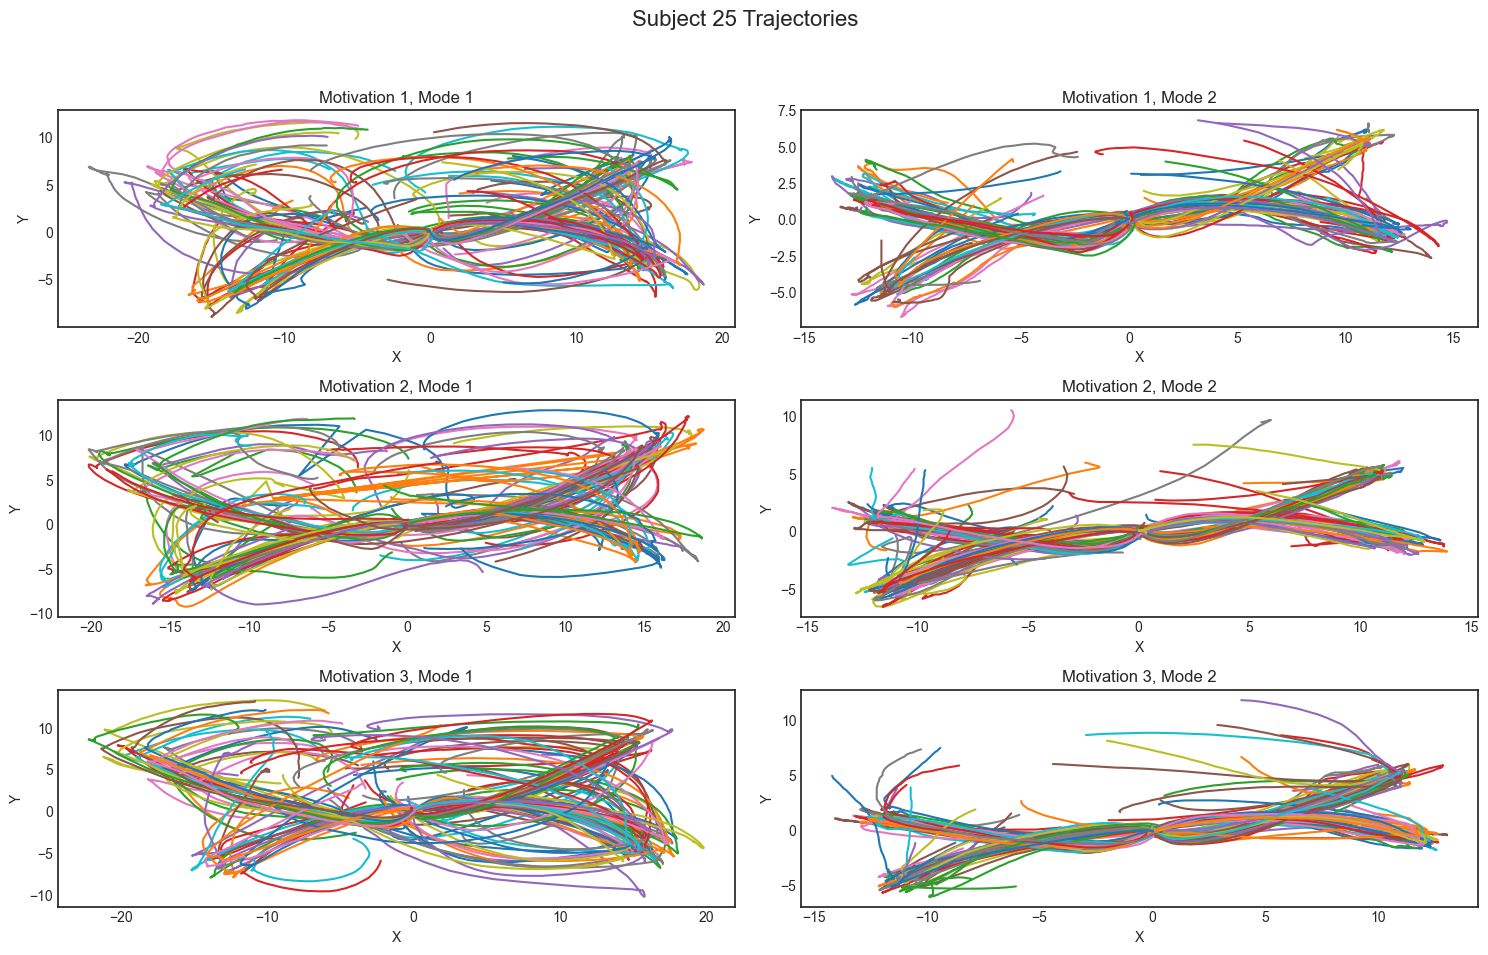

In [5]:
data_dict_20 = load_multiple_data(first_subj = 25, last_subj = 26, 
                       file_names = 'dataTrajectories' ) 
plot_multiple_data(data_dict_20, first_subj = 25, last_subj = 26, save_dir = 'project_plots')

In [7]:
data_dict = load_multiple_data(first_subj = 34, last_subj = 36, 
                       file_names = 'dataTrajectories' ) 
cleaned_data_dict, idxrule_dict = cleaning_clustering_multiple_data(data_dict, 
                                    segments, 
                                    first_subj = 35, last_subj = 36,
                                    save_dir = 'Paper_plots')    

Dataset shape before cleaning:
(178, 2500)
Dataset shape before cleaning:
(178, 2500)
Dataset shape before cleaning:
(95, 2500)
Dataset shape before cleaning:
(91, 2500)
Dataset shape before cleaning:
(102, 2500)
Dataset shape before cleaning:
(92, 2500)


In [77]:
cleaned_data_dict, idxrule_dict = load_processed_mult_data(folder_name='clustered_multiple_data')    

Loading the cleaned data...
CSV and idxrule JSON files have been loaded successfully.


## Plotting and studying parameters: 

### Parameter study for all the subjects together

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-13.027006863757286, pvalue=2.4459607188967322e-29)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9344421625137329, pvalue=8.867243050936224e-10)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-4.501598487361625, pvalue=1.0780131371863227e-05)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9634361267089844, pvalue=1.6472025663460954e-06)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-14.185414014232984, pvalue=3.975377753606875e-33)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9266099333763123, pvalue=1.6788802292833083e-10)
$\sigma$
T-test results:  Ttest_indResult(statistic=5.329043578778999, pvalue=2.3767986177548851e-07)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9652557969093323, pvalue=2.9193408863648074e-06)


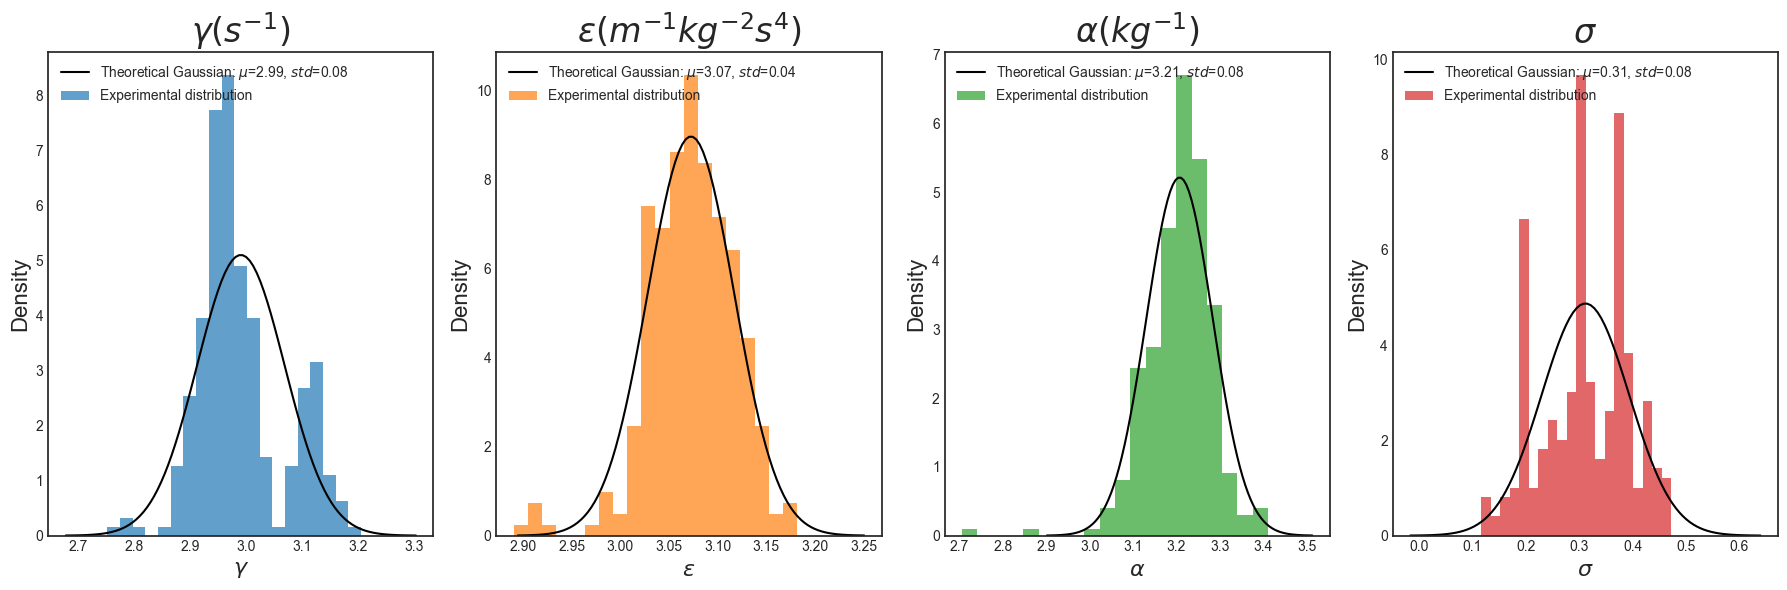

([Ttest_indResult(statistic=-13.027006863757286, pvalue=2.4459607188967322e-29),
  Ttest_indResult(statistic=-4.501598487361625, pvalue=1.0780131371863227e-05),
  Ttest_indResult(statistic=-14.185414014232984, pvalue=3.975377753606875e-33),
  Ttest_indResult(statistic=5.329043578778999, pvalue=2.3767986177548851e-07)],
 [ShapiroResult(statistic=0.9344421625137329, pvalue=8.867243050936224e-10),
  ShapiroResult(statistic=0.9634361267089844, pvalue=1.6472025663460954e-06),
  ShapiroResult(statistic=0.9266099333763123, pvalue=1.6788802292833083e-10),
  ShapiroResult(statistic=0.9652557969093323, pvalue=2.9193408863648074e-06)],
 [2.991229363993396, 3.07262626782757, 3.2071846247071925, 0.3117758171685279],
 [0.07817618719352223,
  0.04448852325684771,
  0.07649410681094634,
  0.08188066356952758])

In [6]:
plotting_dict_params(params_dict = params_loaded, opt_sigma = opt_sigma, 
                         barWidth=0.5, plotting_ = 1,
                         saving_plot = True, folder_name = 'fitted_pics', 
                         pic_name = 'parameters_gaussians_5')

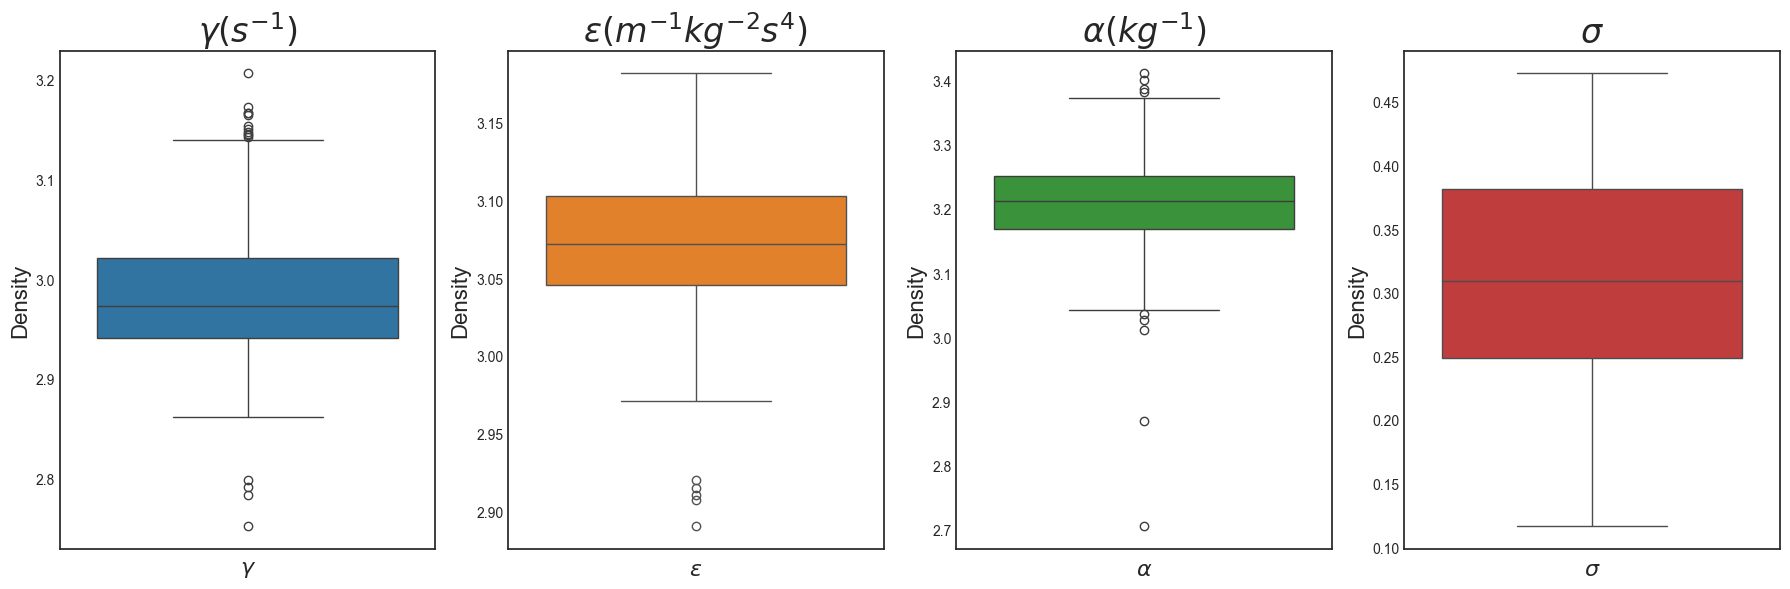

In [7]:
plotting_dict_params(params_dict = params_loaded, opt_sigma = opt_sigma, 
                         barWidth=0.5, plotting_ = 0,
                         saving_plot = True, folder_name = 'fitted_pics', 
                         pic_name = 'parameters_boxplot_5')

### Parameters per motivation level

In [8]:
new_params_motiv = {}
opt_sigma_motiv = {}

for motivation in range(1, 4): 
    for subject in range(25, 37): 
        for mode in range(1, 3): 
            for cluster in range(n_clusters):
                key_ = f'{subject}_{motivation}{mode}_cluster_{cluster}'
                if motivation not in new_params_motiv:
                    new_params_motiv[motivation] = {}
                if motivation not in opt_sigma_motiv:
                    opt_sigma_motiv[motivation] = {}
                
                # Check if the key exists in params_loaded
                if key_ in params_loaded[subject]:
                    new_params_motiv[motivation][key_] = params_loaded[subject][key_]
                else:
                    print(f"Key {key_} not found in params_loaded[{subject}]")
                
                # Check if the key exists in opt_sigma
                if key_ in opt_sigma[subject]:
                    opt_sigma_motiv[motivation][key_] = opt_sigma[subject][key_]
                else:
                    print(f"Key {key_} not found in opt_sigma[{subject}]")
                

Key 26_12_cluster_1 not found in params_loaded[26]
Key 26_12_cluster_1 not found in opt_sigma[26]
Key 27_12_cluster_1 not found in params_loaded[27]
Key 27_12_cluster_1 not found in opt_sigma[27]
Key 26_22_cluster_1 not found in params_loaded[26]
Key 26_22_cluster_1 not found in opt_sigma[26]
Key 26_22_cluster_3 not found in params_loaded[26]
Key 26_22_cluster_3 not found in opt_sigma[26]
Key 29_22_cluster_1 not found in params_loaded[29]
Key 29_22_cluster_1 not found in opt_sigma[29]
Key 29_22_cluster_3 not found in params_loaded[29]
Key 29_22_cluster_3 not found in opt_sigma[29]
Key 29_31_cluster_1 not found in params_loaded[29]
Key 29_31_cluster_1 not found in opt_sigma[29]
Key 29_31_cluster_3 not found in params_loaded[29]
Key 29_31_cluster_3 not found in opt_sigma[29]
Key 29_32_cluster_1 not found in params_loaded[29]
Key 29_32_cluster_1 not found in opt_sigma[29]


#### Gaussianity tests

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-7.002822335436566, pvalue=1.74760665895719e-10)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9301596283912659, pvalue=8.511008491041139e-05)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-3.184380409423789, pvalue=0.0018630555251472596)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9371829628944397, pvalue=0.00021155635477043688)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-9.078880409017941, pvalue=3.4067716080512793e-15)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9432820081710815, pvalue=0.00048440959653817117)
$\sigma$
T-test results:  Ttest_indResult(statistic=3.120143711720635, pvalue=0.002281116848673804)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9685629606246948, pvalue=0.02303253300487995)


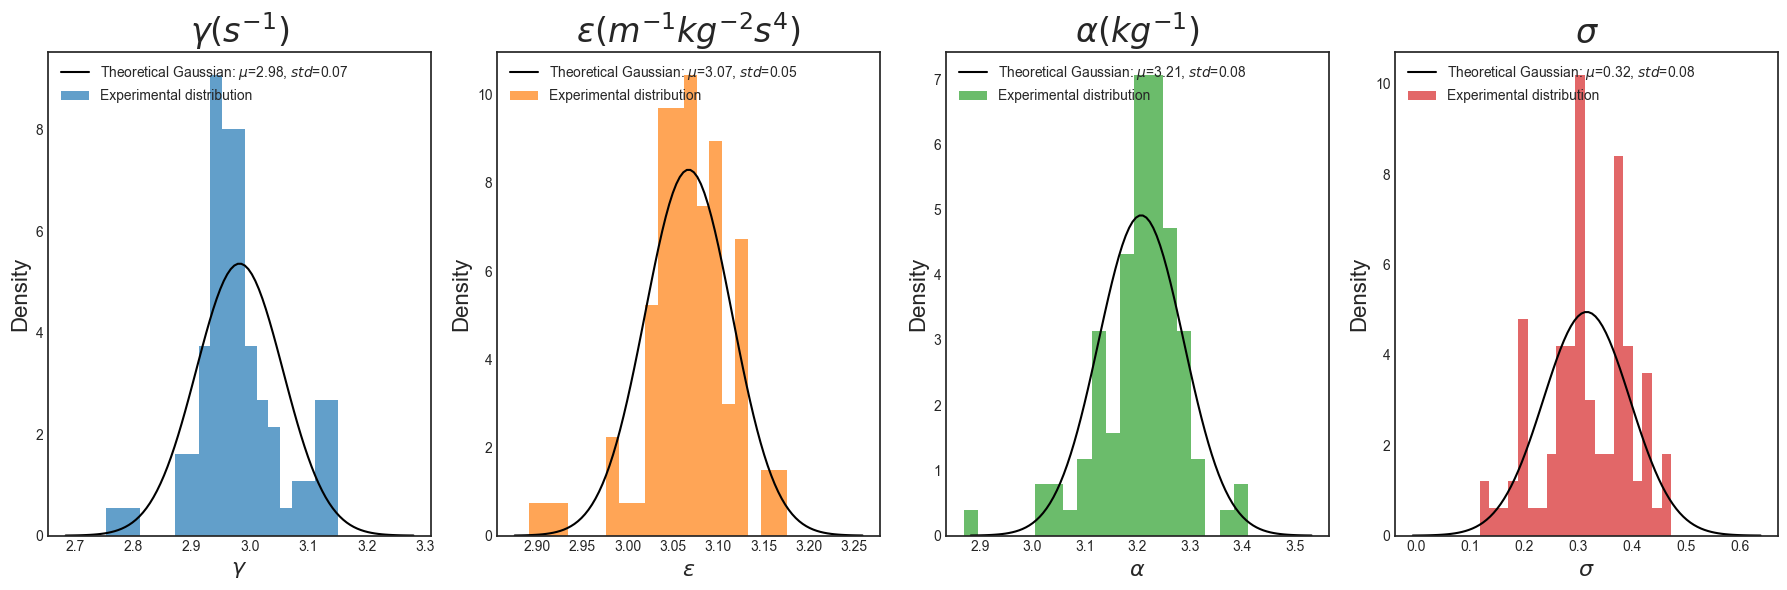

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-7.837978365428212, pvalue=2.6472766555191224e-12)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9461113214492798, pvalue=0.0008358769118785858)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-2.140181980010296, pvalue=0.03447145072184372)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9693230390548706, pvalue=0.028784969821572304)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-6.789701335657102, pvalue=5.337356667867048e-10)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9830185770988464, pvalue=0.2765789031982422)
$\sigma$
T-test results:  Ttest_indResult(statistic=3.1188613448820877, pvalue=0.002299161016587385)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9577486515045166, pvalue=0.004582119174301624)


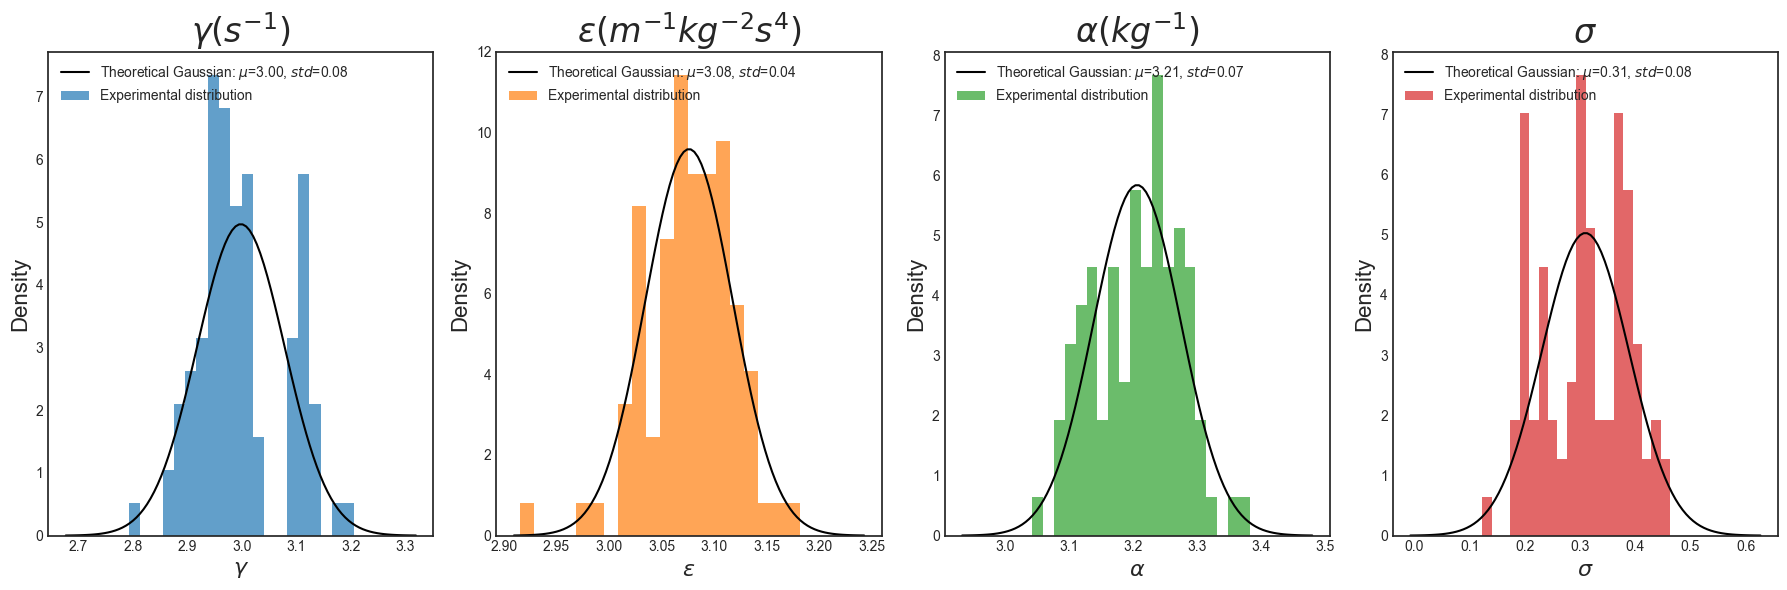

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-7.655866540696942, pvalue=6.51157962779643e-12)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8900976181030273, pvalue=1.071409883479646e-06)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-2.3606553417648817, pvalue=0.019925997390095353)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9656898379325867, pvalue=0.01510864682495594)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-8.649100439708958, pvalue=3.584923854106351e-14)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8172174692153931, pvalue=2.2664887744383577e-09)
$\sigma$
T-test results:  Ttest_indResult(statistic=3.036088121011212, pvalue=0.002965119434745365)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9546329975128174, pvalue=0.0026809191331267357)


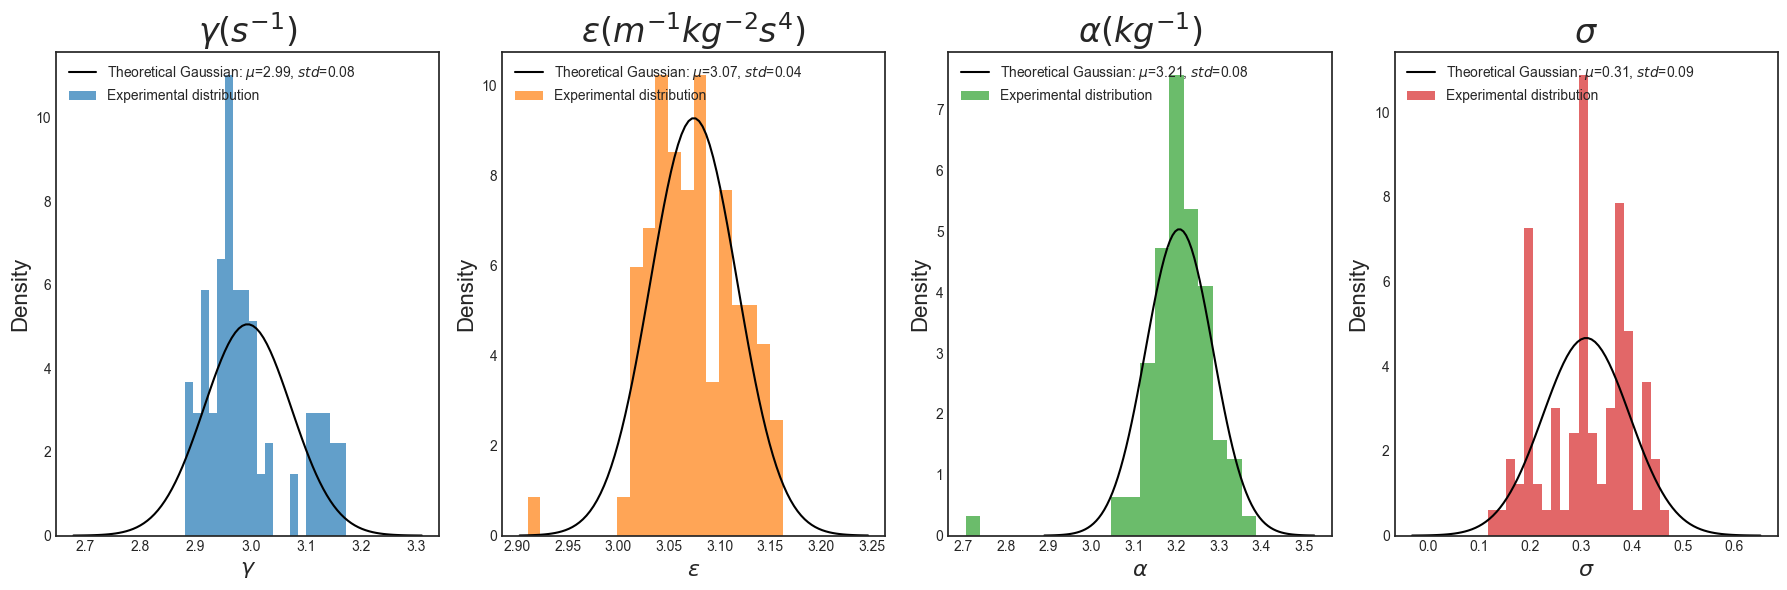

In [9]:
t_tests = []
sw_tests = []
means = []
devs = [] 
for motivation in range(1, 4): 
#subject = 25
    t_tests_, sw_tests_, means_, devs_ = plotting_dict_params(params_dict = new_params_motiv[motivation], opt_sigma = opt_sigma_motiv[motivation], 
                         barWidth=0.5, plotting_ = 1,
                         saving_plot = True, folder_name = 'fitted_pics', 
                         pic_name = f'parameters_gaussians_motiv_values_{motivation}')
    t_tests.append(t_tests_)
    sw_tests.append(sw_tests_)
    means.append(means_)
    devs.append(devs_)

In [11]:
test_results = {}
for subject, subject_means, subject_devs in zip(range(1, 4), means, devs):
    subject_results = [{'mean': mean, 'std': std} for mean, std in zip(subject_means, subject_devs)]
    test_results[subject] = subject_results
   
parameters = ["$\gamma (s^{-1})$", "$\\varepsilon (m^3 kg^2 s^{-4})$", "$\\alpha (kg^{-1})$", "$\sigma$"]

# Generate the LaTeX table
test_name = "Shapiro-Wilk test"
latex_table = generate_latex_table_by_subject(test_results, parameters, test_name)
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Subject & $\gamma (s^{-1})$ & $\varepsilon (m^3 kg^2 s^{-4})$ & $\alpha (kg^{-1})$ & $\sigma$ \\
\hline
1 & $\mathcal{N}(2.9820, 0.0744)$ & $\mathcal{N}(3.0672, 0.0481)$ & $\mathcal{N}(3.2074, 0.0812)$ & $\mathcal{N}(0.3158, 0.0805)$ \\
\hline
2 & $\mathcal{N}(2.9979, 0.0803)$ & $\mathcal{N}(3.0762, 0.0416)$ & $\mathcal{N}(3.2070, 0.0683)$ & $\mathcal{N}(0.3098, 0.0793)$ \\
\hline
3 & $\mathcal{N}(2.9940, 0.0789)$ & $\mathcal{N}(3.0746, 0.0430)$ & $\mathcal{N}(3.2071, 0.0792)$ & $\mathcal{N}(0.3097, 0.0855)$ \\
\hline
\end{tabular}
\caption{Means and deviations for Shapiro-Wilk test test for each parameter for each subject}
\label{tab:means_devs_shapiro-wilk_test}
\end{table}


In [ ]:
def generate_latex_table_by_motivation(test_results, parameters, test_name):
    latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|" + "c|" * len(parameters) + "}\n\\hline\n"
    
    # Add headers
    latex_table += "Motivation & " + " & ".join(parameters) + " \\\\\n\\hline\n"
    
    # Add data rows
    for motivation, motivation_results in enumerate(test_results, start=1):
        pvalues = [f"{result.pvalue:.4e}" for result in motivation_results]
        latex_table += f"{motivation} & " + " & ".join(pvalues) + " \\\\\n"
        
    latex_table += "\\hline\n\\end{tabular}\n\\caption{P-values for " + test_name + " test for each parameter for each motivation}\n\\label{tab:pvalues_" + test_name.lower().replace(' ', '_') + "}\n\\end{table}"
    
    return latex_table

In [ ]:
parameters = ["$\gamma (s^{-1})$", "$\varepsilon (m^3 kg^2 s^{-4})$", "$\alpha (kg^{-1})$", "$\sigma$"]

# Generate LaTeX code for T-test table by motivation
latex_ttest_table_by_motivation = generate_latex_table_by_motivation(t_tests, parameters, "T-test")

# Generate LaTeX code for Shapiro-Wilk test table by motivation
latex_swtest_table_by_motivation = generate_latex_table_by_motivation(sw_tests, parameters, "Shapiro-Wilk")

# Print the LaTeX code
print(latex_ttest_table_by_motivation)
print(latex_swtest_table_by_motivation)

### Parameters per playing mode

In [15]:
new_params_mode = {}
opt_sigma_mode = {}

for mode in range(1, 3): 
    for motivation in range(1, 4): 
        for subject in range(25, 37): 
            
            for cluster in range(n_clusters):
                key_ = f'{subject}_{motivation}{mode}_cluster_{cluster}'
                if mode not in new_params_mode:
                    new_params_mode[mode] = {}
                if mode not in opt_sigma_mode:
                    opt_sigma_mode[mode] = {}
                
                # Check if the key exists in params_loaded
                if key_ in params_loaded[subject]:
                    new_params_mode[mode][key_] = params_loaded[subject][key_]
                else:
                    print(f"Key {key_} not found in params_loaded[{subject}]")
                
                # Check if the key exists in opt_sigma
                if key_ in opt_sigma[subject]:
                    opt_sigma_mode[mode][key_] = opt_sigma[subject][key_]
                else:
                    print(f"Key {key_} not found in opt_sigma[{subject}]")
                

Key 29_31_cluster_1 not found in params_loaded[29]
Key 29_31_cluster_1 not found in opt_sigma[29]
Key 29_31_cluster_3 not found in params_loaded[29]
Key 29_31_cluster_3 not found in opt_sigma[29]
Key 26_12_cluster_1 not found in params_loaded[26]
Key 26_12_cluster_1 not found in opt_sigma[26]
Key 27_12_cluster_1 not found in params_loaded[27]
Key 27_12_cluster_1 not found in opt_sigma[27]
Key 26_22_cluster_1 not found in params_loaded[26]
Key 26_22_cluster_1 not found in opt_sigma[26]
Key 26_22_cluster_3 not found in params_loaded[26]
Key 26_22_cluster_3 not found in opt_sigma[26]
Key 29_22_cluster_1 not found in params_loaded[29]
Key 29_22_cluster_1 not found in opt_sigma[29]
Key 29_22_cluster_3 not found in params_loaded[29]
Key 29_22_cluster_3 not found in opt_sigma[29]
Key 29_32_cluster_1 not found in params_loaded[29]
Key 29_32_cluster_1 not found in opt_sigma[29]


#### Gaussianity tests

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-12.576259841108506, pvalue=6.0912133498603485e-25)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9415062665939331, pvalue=1.1721151167876087e-05)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-4.535970840434994, pvalue=1.1984416697946846e-05)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9445983171463013, pvalue=2.0082721675862558e-05)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-12.745717447940944, pvalue=2.1932723539303667e-25)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9276216626167297, pvalue=1.2339527302174247e-06)
$\sigma$
T-test results:  Ttest_indResult(statistic=3.73532880799878, pvalue=0.0002694523846739606)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9523093104362488, pvalue=8.236960275098681e-05)


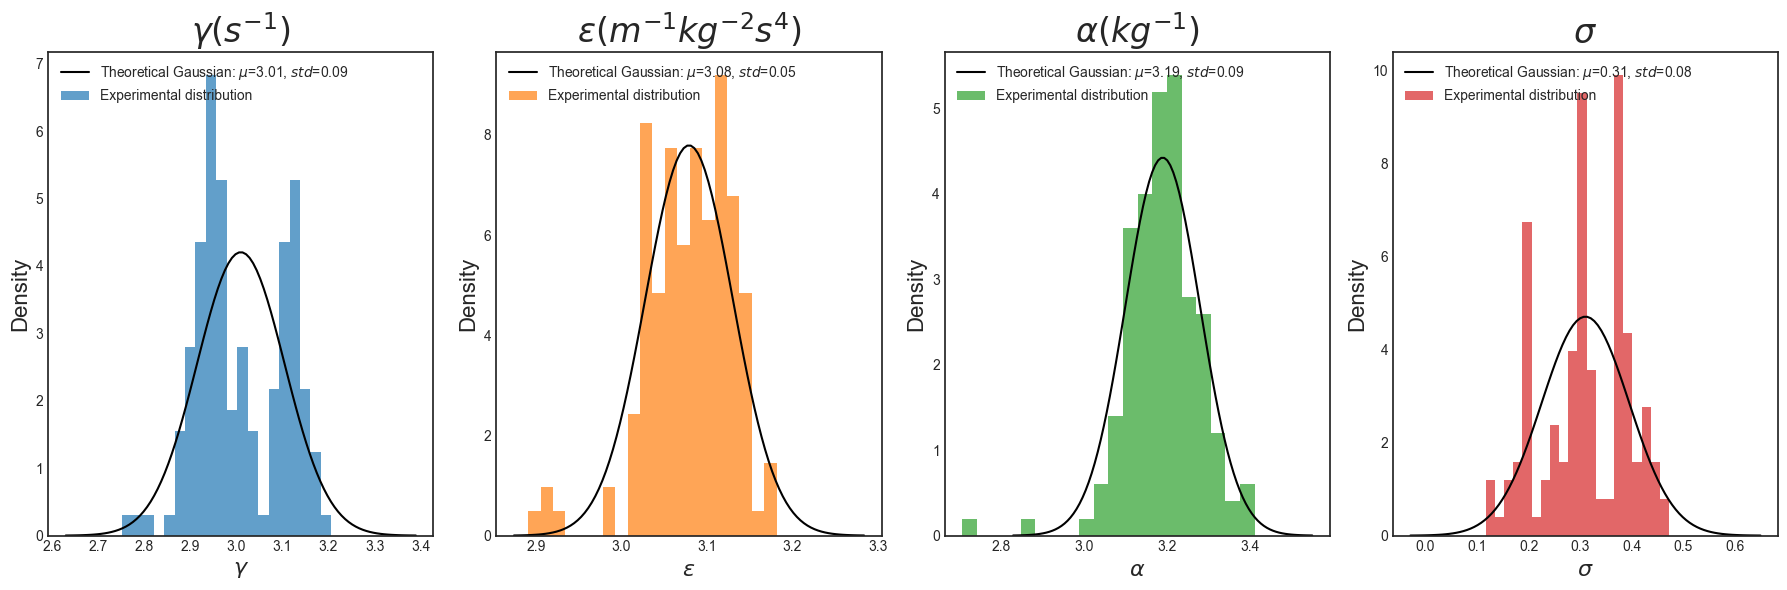

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-3.6631511932649587, pvalue=0.00035166640768907574)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9233839511871338, pvalue=9.620671335142106e-07)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-1.327748840528204, pvalue=0.18640662218199702)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9749419689178467, pvalue=0.012558599933981895)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-5.313570180786221, pvalue=4.1014858990508765e-07)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9767963886260986, pvalue=0.01940883882343769)
$\sigma$
T-test results:  Ttest_indResult(statistic=3.7957564569496456, pvalue=0.00021789853774872476)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9731031656265259, pvalue=0.008211677893996239)


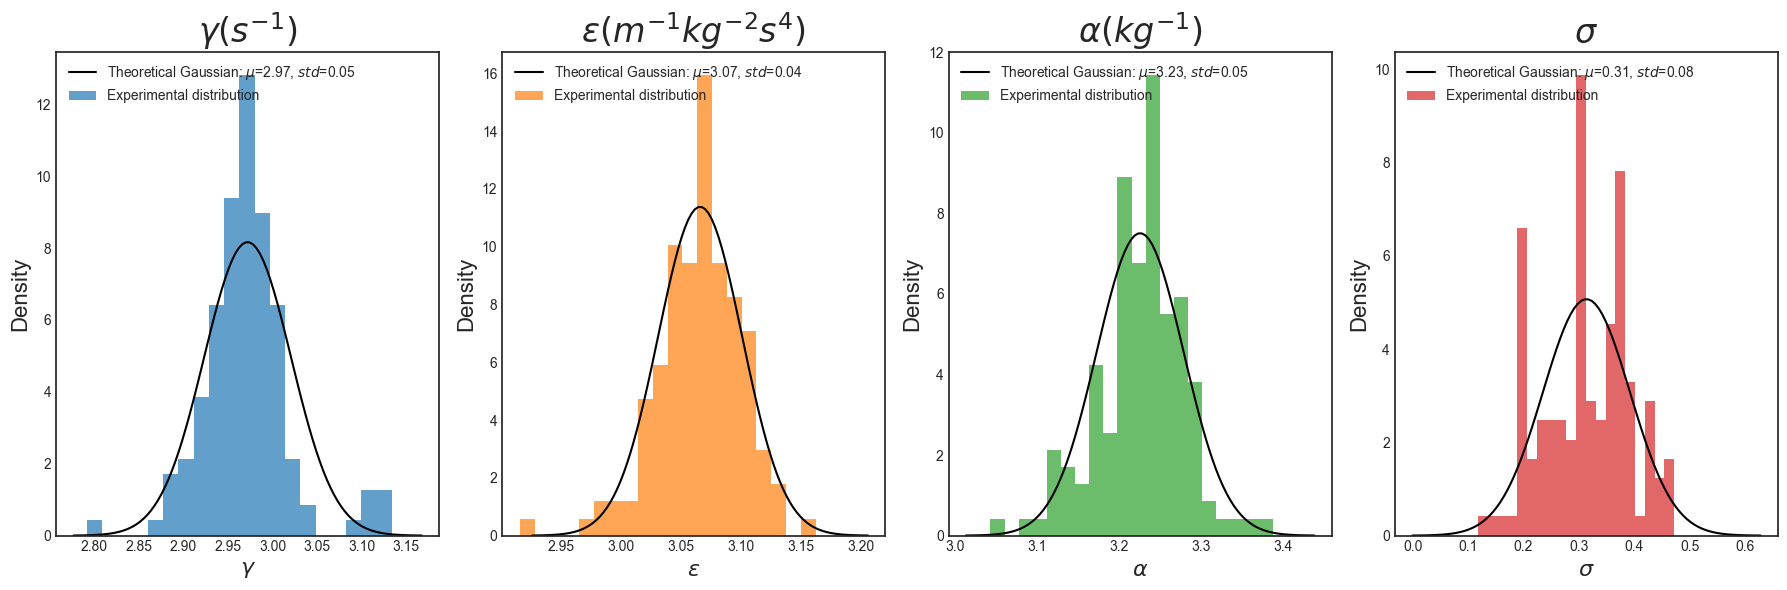

In [16]:
t_tests = []
sw_tests = []
means = []
devs = [] 
for mode in range(1, 3): 
#subject = 25
    t_tests_, sw_tests_, means_, devs_  = plotting_dict_params(params_dict = new_params_mode[mode], opt_sigma = opt_sigma_mode[mode], 
                         barWidth=0.5, plotting_ = 1,
                         saving_plot = True, folder_name = 'fitted_pics', 
                         pic_name = f'parameters_gaussians_mode_{mode}')
    t_tests.append(t_tests_)
    sw_tests.append(sw_tests_)
    means.append(means_)
    devs.append(devs_)

In [17]:
test_results = {}
for subject, subject_means, subject_devs in zip(range(1, 4), means, devs):
    subject_results = [{'mean': mean, 'std': std} for mean, std in zip(subject_means, subject_devs)]
    test_results[subject] = subject_results
   
parameters = ["$\gamma (s^{-1})$", "$\\varepsilon (m^3 kg^2 s^{-4})$", "$\\alpha (kg^{-1})$", "$\sigma$"]

# Generate the LaTeX table
test_name = "Shapiro-Wilk test"
latex_table = generate_latex_table_by_subject(test_results, parameters, test_name)
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Subject & $\gamma (s^{-1})$ & $\varepsilon (m^3 kg^2 s^{-4})$ & $\alpha (kg^{-1})$ & $\sigma$ \\
\hline
1 & $\mathcal{N}(3.0097, 0.0949)$ & $\mathcal{N}(3.0790, 0.0512)$ & $\mathcal{N}(3.1894, 0.0902)$ & $\mathcal{N}(0.3100, 0.0848)$ \\
\hline
2 & $\mathcal{N}(2.9721, 0.0488)$ & $\mathcal{N}(3.0660, 0.0350)$ & $\mathcal{N}(3.2256, 0.0531)$ & $\mathcal{N}(0.3136, 0.0787)$ \\
\hline
\end{tabular}
\caption{Means and deviations for Shapiro-Wilk test test for each parameter for each subject}
\label{tab:means_devs_shapiro-wilk_test}
\end{table}


In [17]:
def generate_latex_table_by_mode(test_results, parameters, test_name):
    latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|" + "c|" * len(parameters) + "}\n\\hline\n"
    
    # Add headers
    latex_table += "Mode & " + " & ".join(parameters) + " \\\\\n\\hline\n"
    
    # Add data rows
    for motivation, motivation_results in enumerate(test_results, start=1):
        pvalues = [f"{result.pvalue:.2e}" for result in motivation_results]
        latex_table += f"{motivation} & " + " & ".join(pvalues) + " \\\\\n"
        
    latex_table += "\\hline\n\\end{tabular}\n\\caption{P-values for " + test_name + " test for each parameter for each playing mode}\n\\label{tab:pvalues_" + test_name.lower().replace(' ', '_') + "}\n\\end{table}"
    
    return latex_table


In [18]:
parameters = ["$\gamma (s^{-1})$", "$\varepsilon (m^3 kg^2 s^{-4})$", "$\alpha (kg^{-1})$", "$\sigma$"]

# Generate LaTeX code for T-test table by motivation
latex_ttest_table_by_mode = generate_latex_table_by_mode(t_tests, parameters, "T-test")

# Generate LaTeX code for Shapiro-Wilk test table by motivation
latex_swtest_table_by_mode = generate_latex_table_by_mode(sw_tests, parameters, "Shapiro-Wilk")

# Print the LaTeX code
print(latex_ttest_table_by_mode)
print(latex_swtest_table_by_mode)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Mode & $\gamma (s^{-1})$ & $arepsilon (m^3 kg^2 s^{-4})$ & $lpha (kg^{-1})$ & $\sigma$ \\
\hline
1 & 6.09e-25 & 1.20e-05 & 2.19e-25 & 6.74e-61 \\
2 & 3.52e-04 & 1.86e-01 & 4.10e-07 & 3.53e-68 \\
\hline
\end{tabular}
\caption{P-values for T-test test for each parameter for each playing mode}
\label{tab:pvalues_t-test}
\end{table}
\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Mode & $\gamma (s^{-1})$ & $arepsilon (m^3 kg^2 s^{-4})$ & $lpha (kg^{-1})$ & $\sigma$ \\
\hline
1 & 1.17e-05 & 2.01e-05 & 1.23e-06 & 8.24e-05 \\
2 & 9.62e-07 & 1.26e-02 & 1.94e-02 & 8.21e-03 \\
\hline
\end{tabular}
\caption{P-values for Shapiro-Wilk test for each parameter for each playing mode}
\label{tab:pvalues_shapiro-wilk}
\end{table}


#### Chi-squared test over the $\sigma$ parameter

In [43]:
import seaborn as sns
from scipy.stats import norm, expon, gamma, chi2, kstest


def fit_and_test_distributions(sigma_data):
    distributions = {
        'Normal': norm,
        'Exponential': expon,
        'Gamma': gamma,
        'Chi-squared': chi2
    }

    for dist_name, dist in distributions.items():
        params = dist.fit(sigma_data)
        # Define the CDF function based on the fitted parameters
        cdf_func = lambda x: dist.cdf(x, *params)
        ks_stat, ks_p_value = kstest(sigma_data, cdf_func)
        print(f'{dist_name} K-S Statistic: {ks_stat:.4f}, P-value: {ks_p_value:.4f}')


def plot_histogram_with_distributions(sigma_data, distributions, bins='auto'):
    plt.figure(figsize=(10, 6))
    sns.histplot(sigma_data, bins=bins, kde=False, stat="density", label='Data', color='blue', alpha=0.6)

    x = np.linspace(min(sigma_data), max(sigma_data), 1000)
    
    for dist_name, dist in distributions.items():
        params = dist.fit(sigma_data)
        pdf_fitted = dist.pdf(x, *params)
        plt.plot(x, pdf_fitted, label=f'{dist_name} fit')

    plt.legend()
    plt.xlabel('Sigma')
    plt.ylabel('Density')
    plt.title('Histogram of Sigma with Various Distribution Fits')
    plt.show()

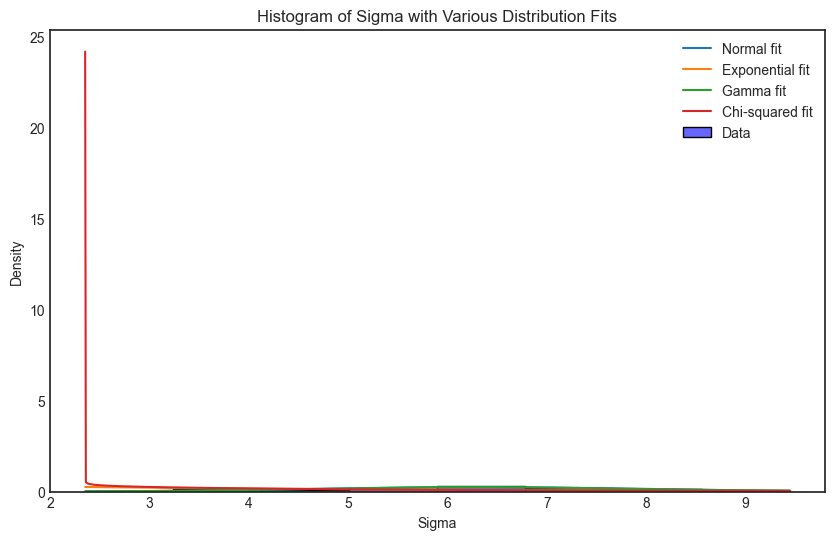

Normal K-S Statistic: 0.1012, P-value: 0.2715
Exponential K-S Statistic: 0.3106, P-value: 0.0000
Gamma K-S Statistic: 0.0989, P-value: 0.2970
Chi-squared K-S Statistic: 0.3862, P-value: 0.0000


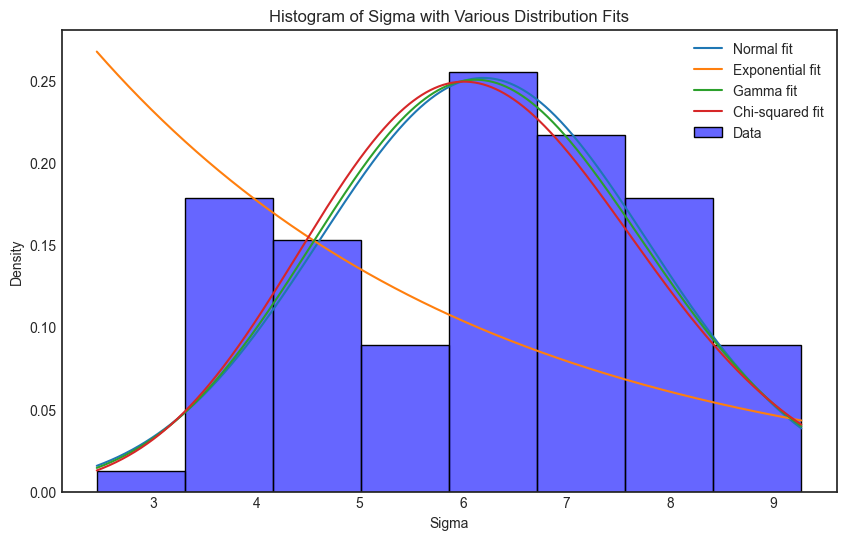

Normal K-S Statistic: 0.1023, P-value: 0.2719
Exponential K-S Statistic: 0.2813, P-value: 0.0000
Gamma K-S Statistic: 0.1085, P-value: 0.2127
Chi-squared K-S Statistic: 0.1194, P-value: 0.1335


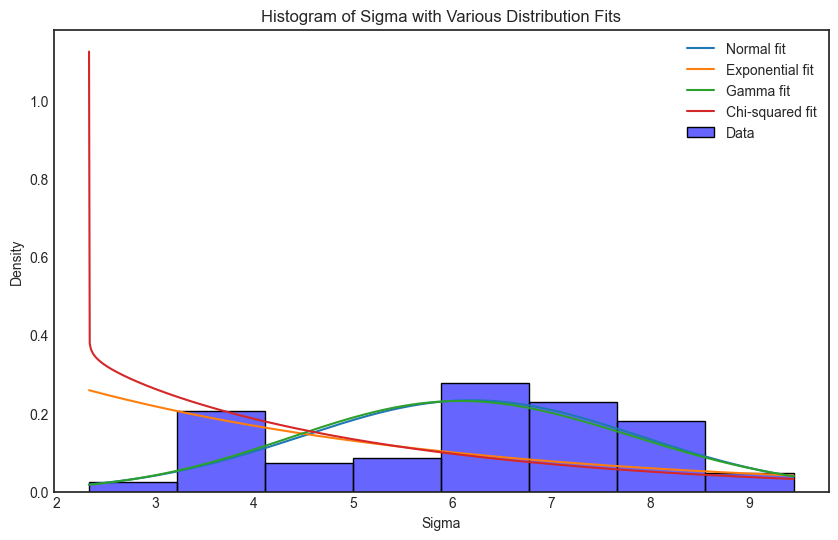

Normal K-S Statistic: 0.1164, P-value: 0.1485
Exponential K-S Statistic: 0.2800, P-value: 0.0000
Gamma K-S Statistic: 0.1193, P-value: 0.1303
Chi-squared K-S Statistic: 0.3637, P-value: 0.0000


In [44]:
ks_tests = []
for motivation in range(1, 4): 
    sigma_params__ = dict_to_array( opt_sigma_motiv[motivation])
    sigma_params__ = sigma_params__.flatten()  
    # Plot histogram with distribution fits
    plot_histogram_with_distributions(sigma_params__, {
        'Normal': norm,
        'Exponential': expon,
        'Gamma': gamma,
        'Chi-squared': chi2
    })
    
    # Fit and test distributions
    fit_and_test_distributions(sigma_params__)

In [36]:
from scipy.stats import chi2, chisquare, kstest

def statistical_tests(opt_sigma, test = 'chi2'): 
    sigma_array = dict_to_array(opt_sigma)
    sigma_array = sigma_array.flatten()  
    
    # Kolmogorov-Smirnov Test
    df = 2 
    ks_stat, ks_p_value = kstest(sigma_array, test, args=(df,))
    print(f"K-S Statistic: {ks_stat:.4f}")
    print(f"K-S P-value: {ks_p_value:.4f}")
    
    return ks_stat, ks_p_value

### Parameter study per subject: 

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-5.72651704840586, pvalue=2.0684899859196459e-07)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8827743530273438, pvalue=0.009454773738980293)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-1.7292386265521489, pvalue=0.08793613731259925)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.971977174282074, pvalue=0.7158714532852173)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-3.0724949860581985, pvalue=0.0029703160212361957)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9790664911270142, pvalue=0.8780555725097656)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.5895010856183138, pvalue=0.11621091639758094)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9345205426216125, pvalue=0.12304744124412537)


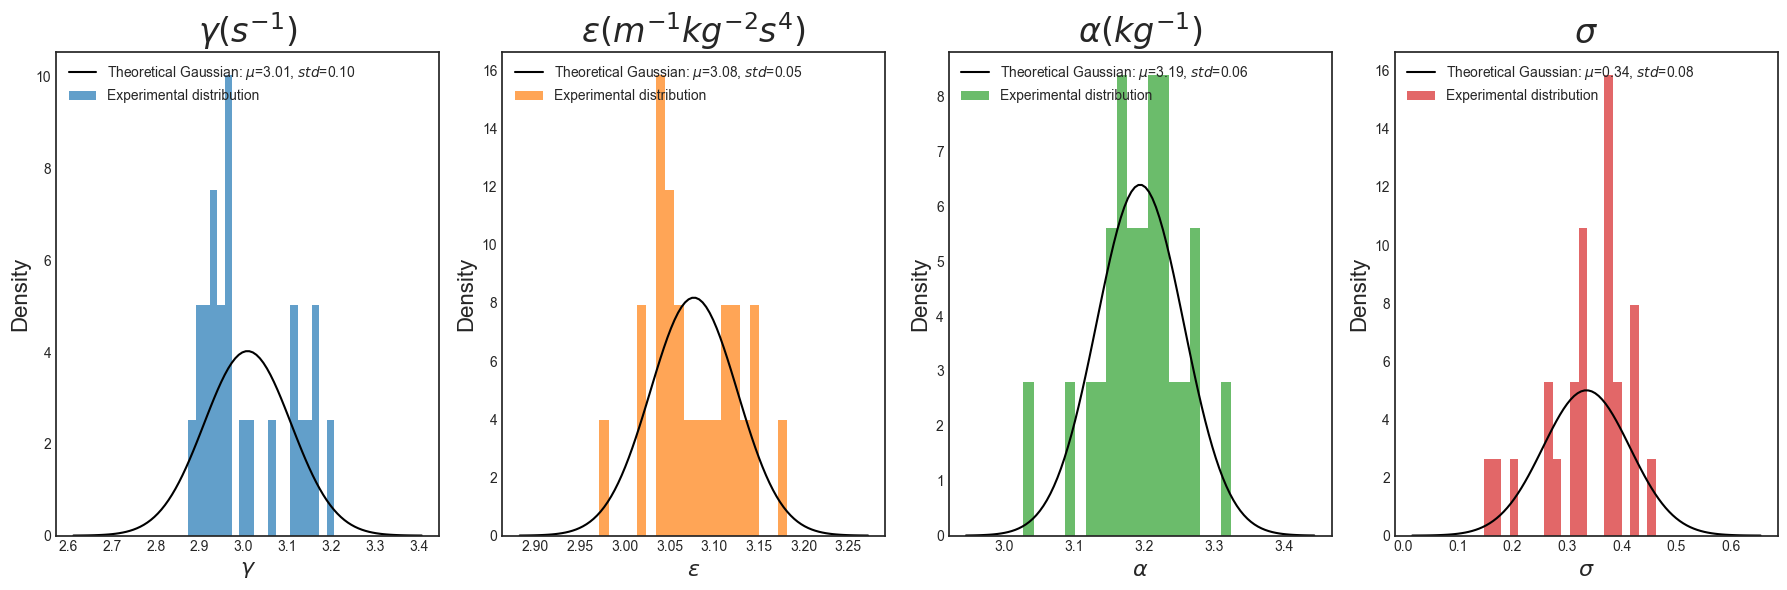

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-3.42052216601887, pvalue=0.0010398301006630715)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8742807507514954, pvalue=0.011461195535957813)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-0.3425306464721039, pvalue=0.732963565407005)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9526373744010925, pvalue=0.38165411353111267)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-2.181181571249161, pvalue=0.032483460418492045)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9534929990768433, pvalue=0.3957805633544922)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.5693071199126305, pvalue=0.12102266333360283)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9713225364685059, pvalue=0.7621306777000427)


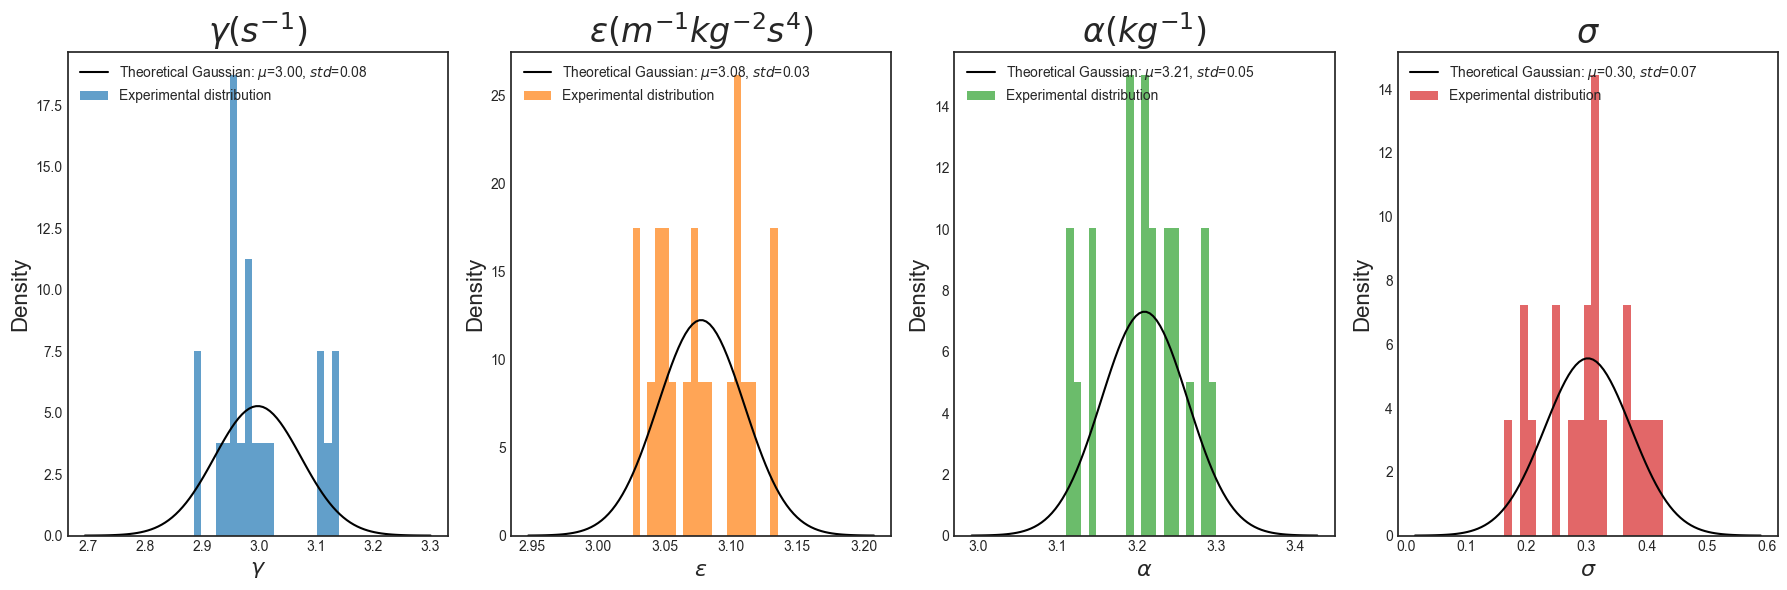

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-0.36414020850870954, pvalue=0.716805926664029)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9667249917984009, pvalue=0.611161470413208)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-1.1944484615342785, pvalue=0.23616920298722197)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.864795446395874, pvalue=0.005106559954583645)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-7.521892621072211, pvalue=1.1100323696340688e-10)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.5425859689712524, pvalue=2.245049017801648e-07)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.4972319175019748, pvalue=0.13864445825430638)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8527677059173584, pvalue=0.0030549298971891403)


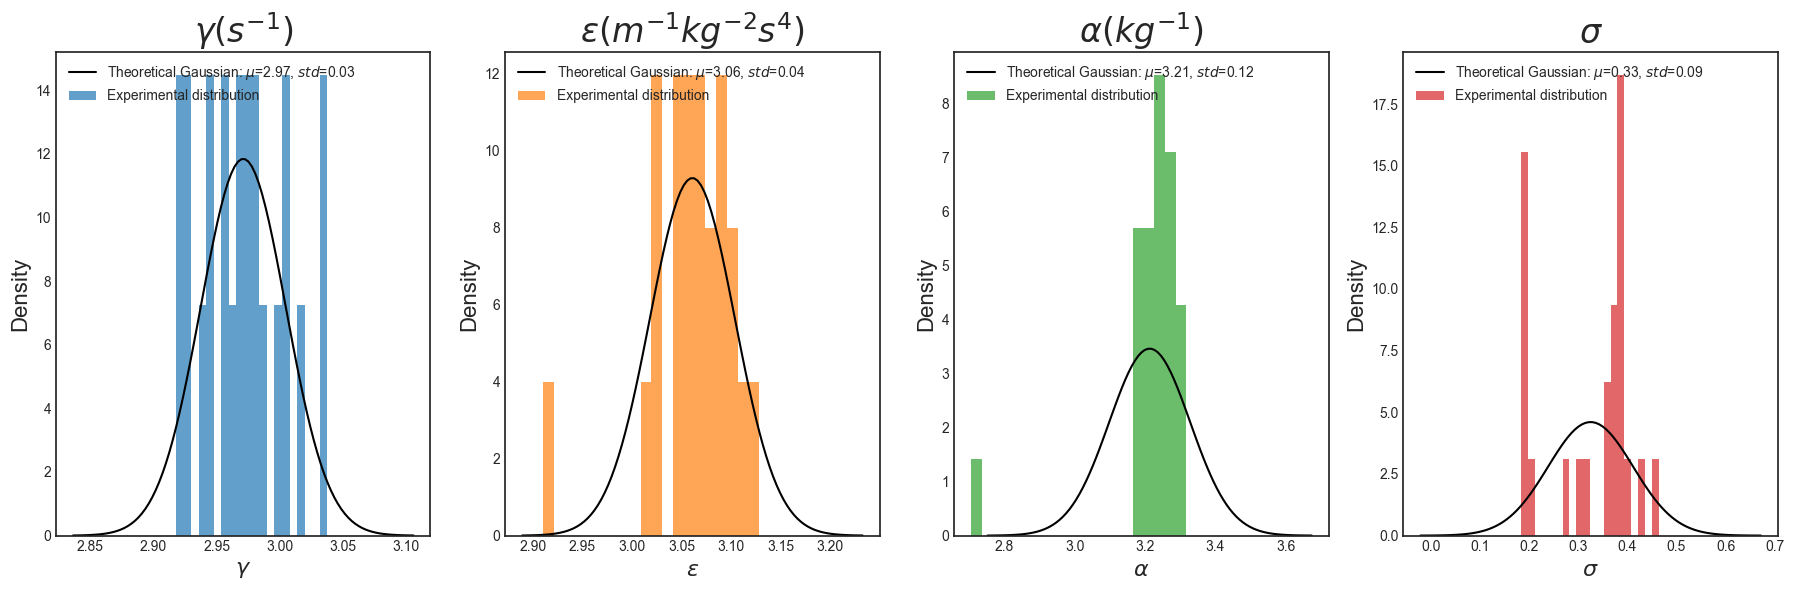

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-4.86105469037306, pvalue=6.376061766849633e-06)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.907282292842865, pvalue=0.030805356800556183)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-1.3885021761979994, pvalue=0.16914969334835017)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.906048595905304, pvalue=0.028977420181035995)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-5.694780607295552, pvalue=2.3541544318037833e-07)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8777610659599304, pvalue=0.007493461482226849)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.6577713926092545, pvalue=0.10159729555244414)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9673009514808655, pvalue=0.6010066866874695)


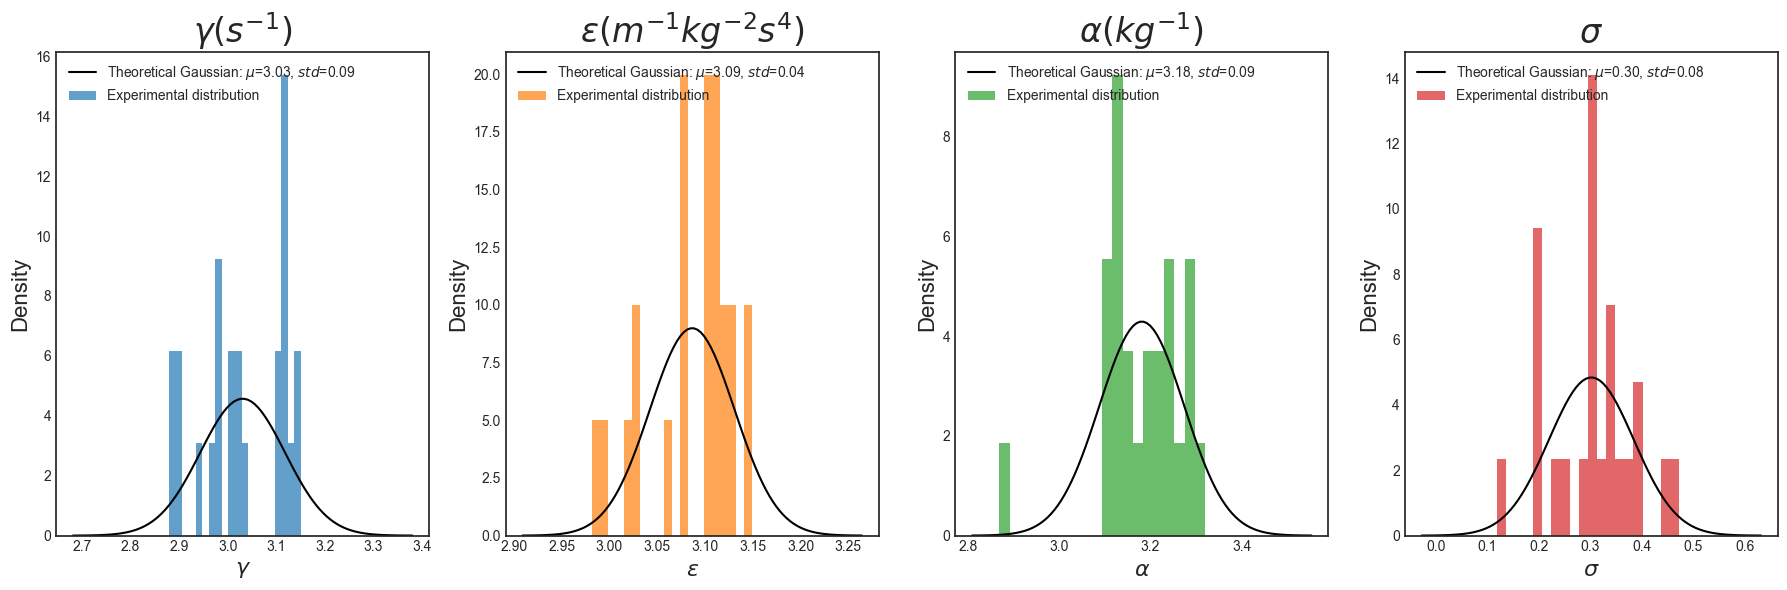

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=0.11935400612625217, pvalue=0.9053319702696714)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9216005802154541, pvalue=0.1211501881480217)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=0.1758459690908743, pvalue=0.8609155300890793)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9337371587753296, pvalue=0.20286662876605988)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-0.8376400169644772, pvalue=0.4050437998027606)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9295839667320251, pvalue=0.17015968263149261)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.506402139373539, pvalue=0.13640043130356558)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9692049622535706, pvalue=0.7604514360427856)


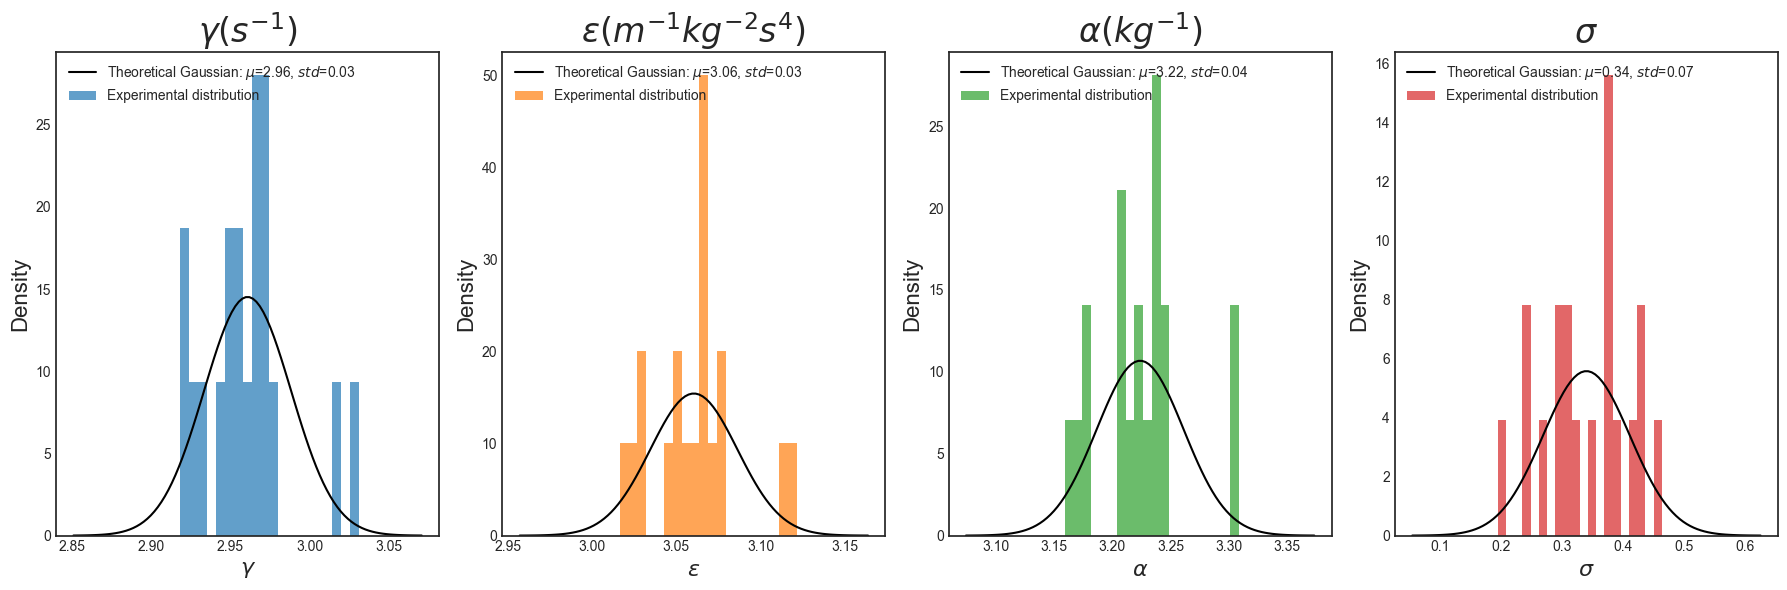

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-4.458242920035982, pvalue=2.8896463130199473e-05)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9650515913963318, pvalue=0.5478798151016235)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-1.7251345220293601, pvalue=0.08867751329608654)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8745274543762207, pvalue=0.006460648030042648)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-4.226723953751162, pvalue=6.687705274799403e-05)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9471634030342102, pvalue=0.235004723072052)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.4955637833604938, pvalue=0.13902007134934502)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9230701923370361, pvalue=0.0683119148015976)


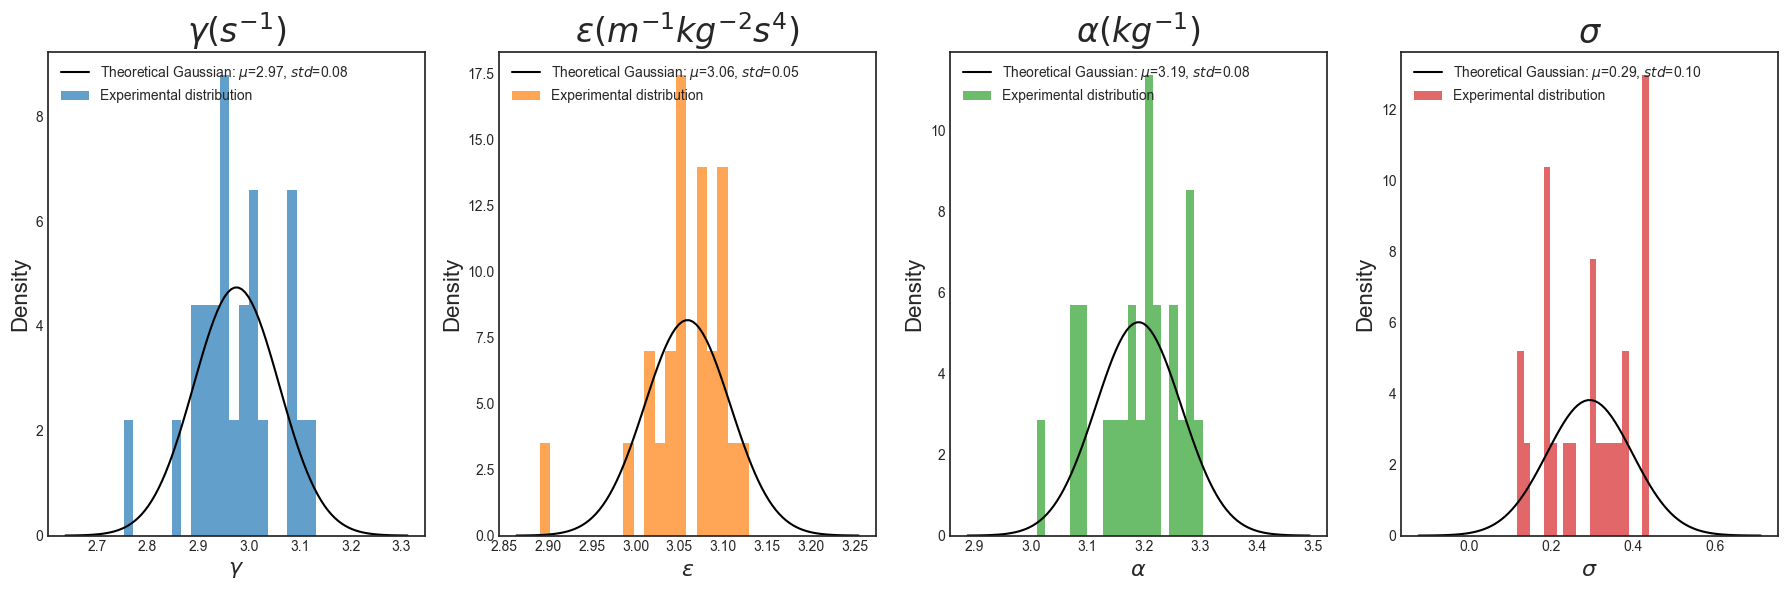

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-0.3794868073229747, pvalue=0.7054132437728107)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9595983028411865, pvalue=0.43040549755096436)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-0.19855994168878938, pvalue=0.843151500437199)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9701787233352661, pvalue=0.6714029312133789)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-1.495644717294538, pvalue=0.13899900392309733)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9684900045394897, pvalue=0.6298584342002869)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.6176471299338668, pvalue=0.10999372318339662)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.897988498210907, pvalue=0.01951540820300579)


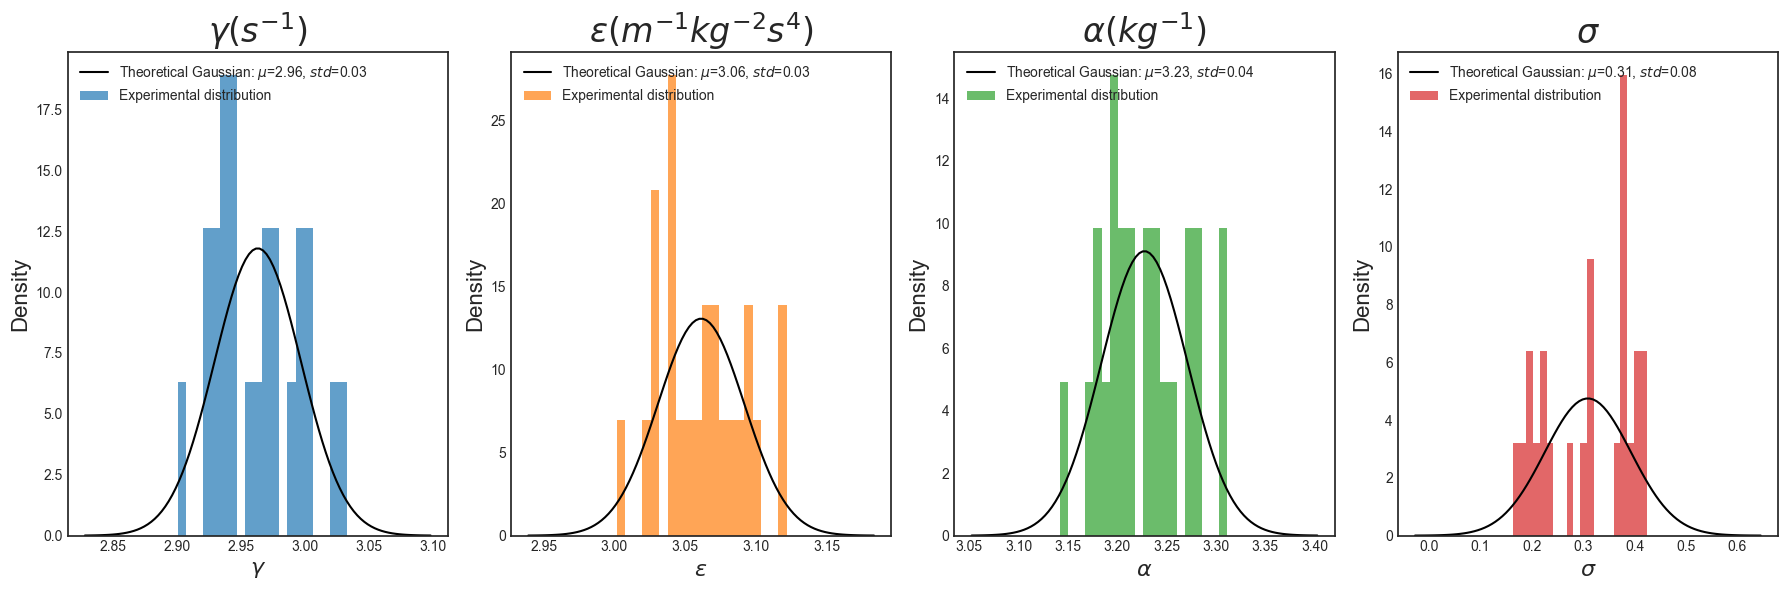

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-3.941965358791733, pvalue=0.00018167786344657692)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9019749164581299, pvalue=0.023706890642642975)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-2.6228518251748785, pvalue=0.0105822773487376)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8954806327819824, pvalue=0.017284028232097626)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-4.8915527947306305, pvalue=5.672884863163588e-06)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9333016872406006, pvalue=0.11555718630552292)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.8527801577259486, pvalue=0.06790117606372516)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.945236325263977, pvalue=0.2131602168083191)


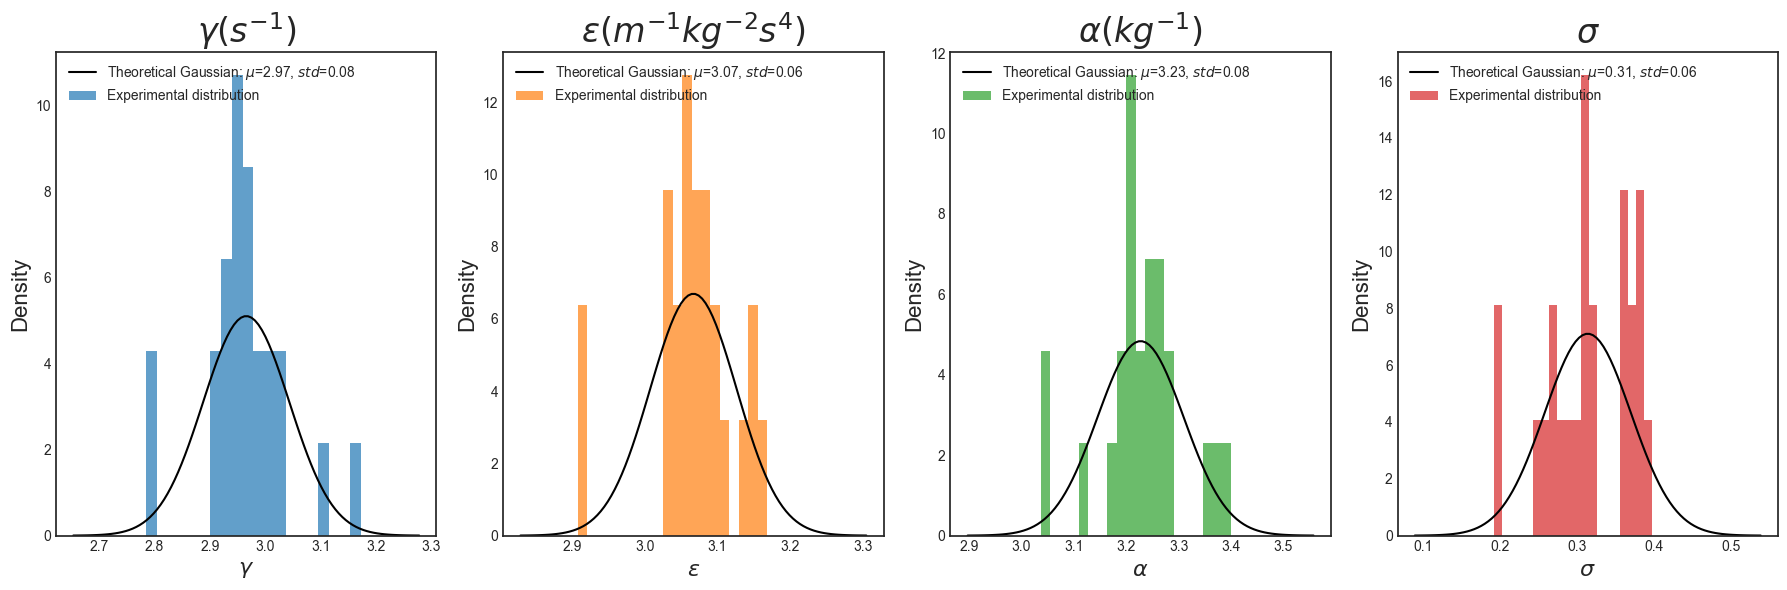

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-3.8365111967971193, pvalue=0.00026048574173485395)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8558893203735352, pvalue=0.00281732901930809)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-0.4756327640758702, pvalue=0.6357371217987591)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9717110991477966, pvalue=0.7093039751052856)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-3.187265051271799, pvalue=0.002104763156633991)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9307361841201782, pvalue=0.10125206410884857)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.6758205807685276, pvalue=0.0979939473628856)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9596734642982483, pvalue=0.431897908449173)


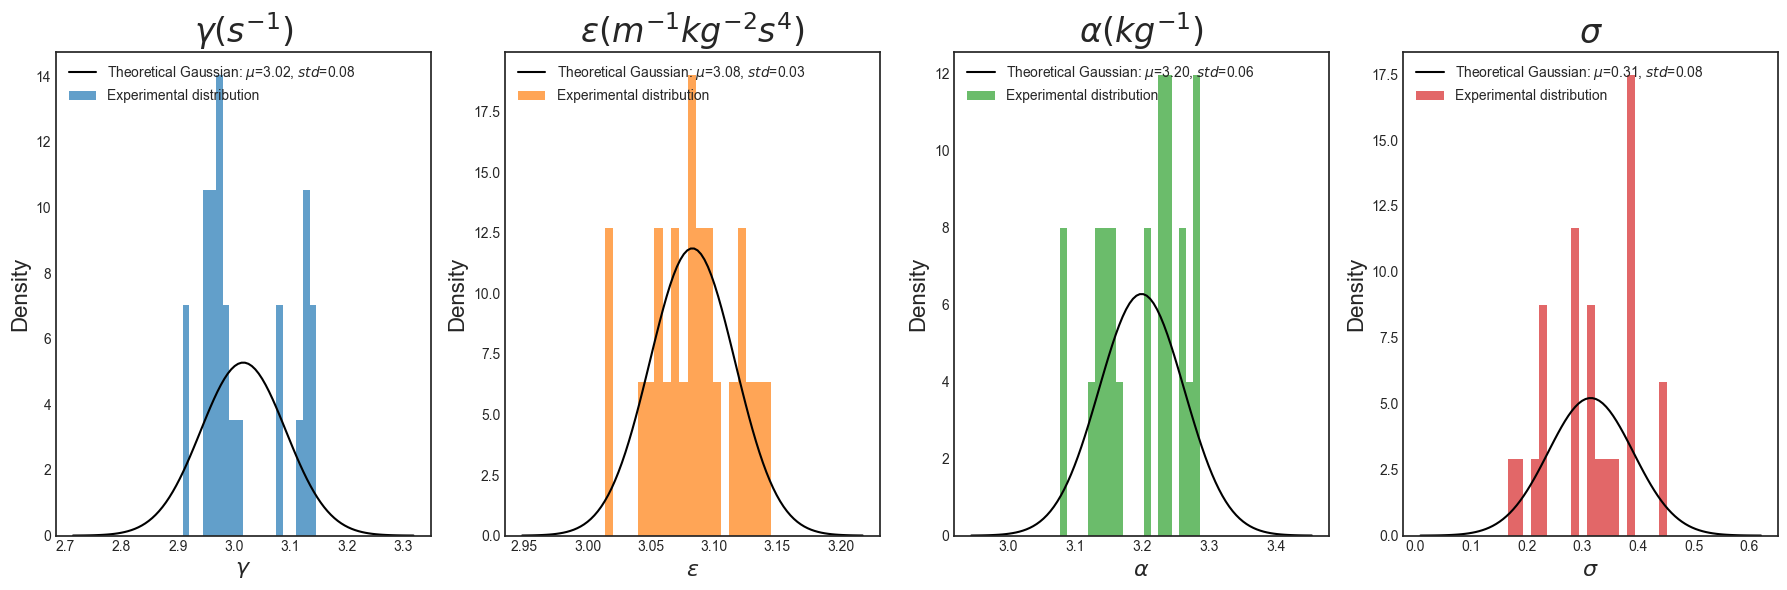

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-4.321562271743904, pvalue=4.755472739231864e-05)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.8839253187179565, pvalue=0.009977535344660282)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-0.9172094785291706, pvalue=0.36201256677862703)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9706148505210876, pvalue=0.6821889877319336)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-3.215907555397029, pvalue=0.0019290183880515057)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9510461688041687, pvalue=0.28541290760040283)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.6480413812379184, pvalue=0.10358402210422256)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.93797367811203, pvalue=0.14699240028858185)


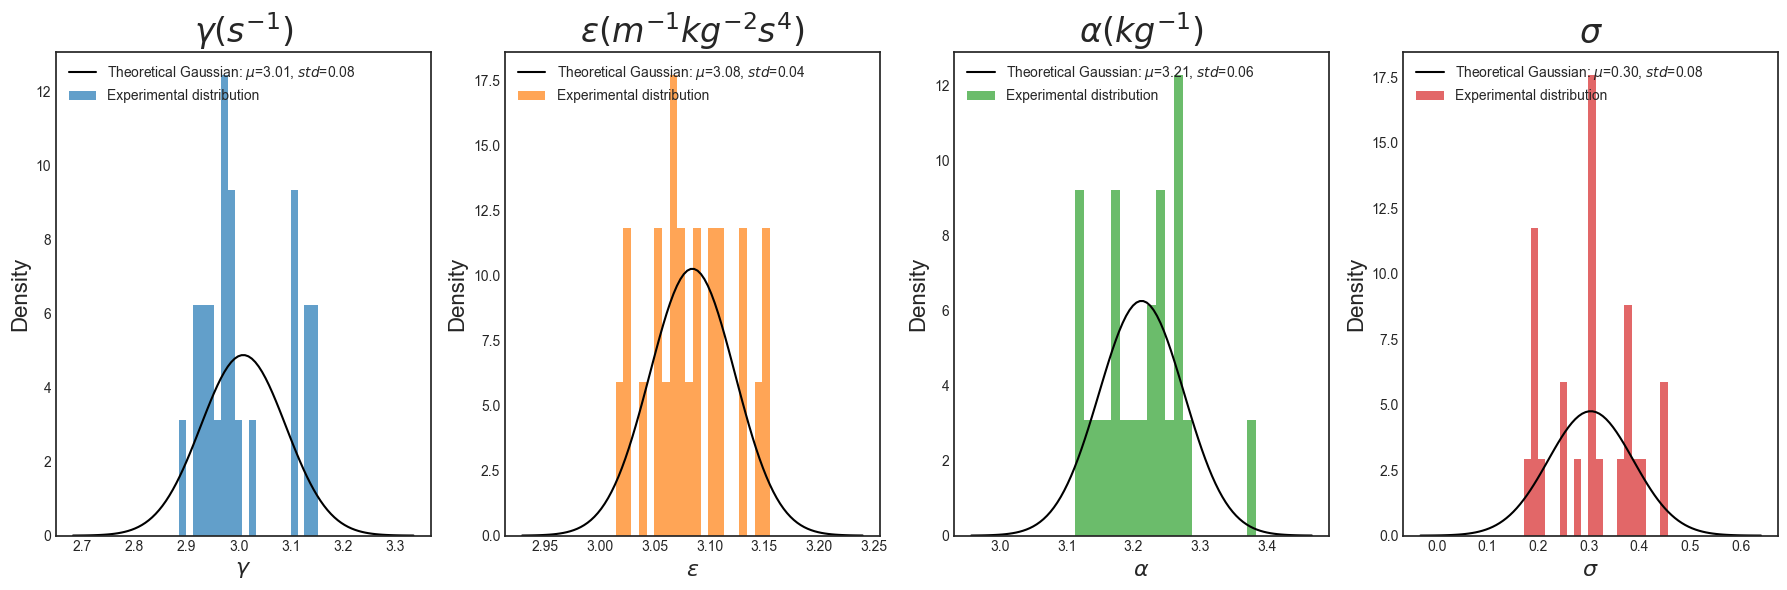

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-3.946420386355717, pvalue=0.00017891190174606665)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9184706211090088, pvalue=0.054039932787418365)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-1.2166910308964556, pvalue=0.22758817540818815)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9912631511688232, pvalue=0.9983955025672913)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-4.444045274159539, pvalue=3.0442125793087756e-05)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.959648847579956, pvalue=0.43140873312950134)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.6561975035138634, pvalue=0.10191654592339634)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9832627773284912, pvalue=0.9475417137145996)


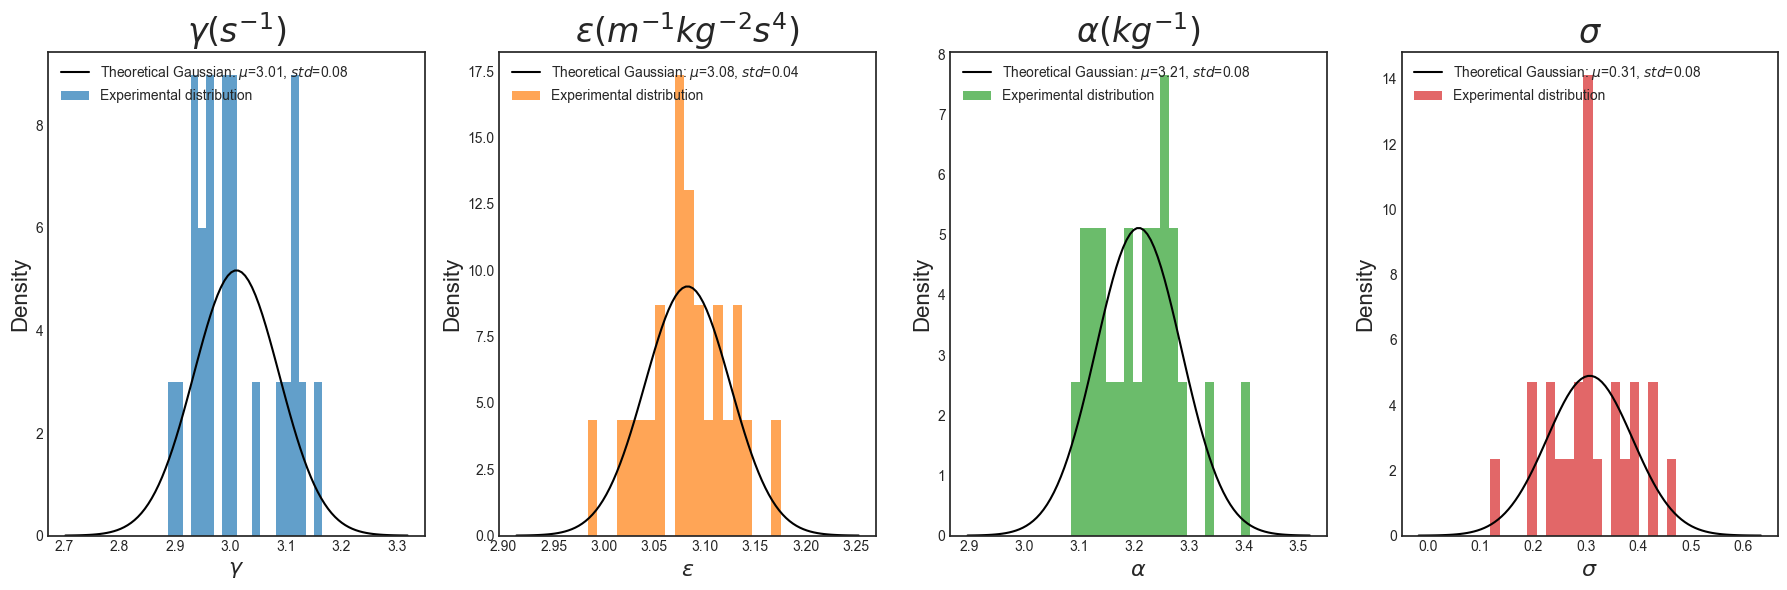

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-4.852267862561009, pvalue=6.5939772790138254e-06)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9422799348831177, pvalue=0.1833401322364807)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=-2.1845563045983614, pvalue=0.032089003455077106)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9498113989830017, pvalue=0.268410861492157)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-5.476601800108807, pvalue=5.690037384402293e-07)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9595307111740112, pvalue=0.42906713485717773)
$\sigma$
T-test results:  Ttest_indResult(statistic=1.694554380868188, pvalue=0.0943648034372022)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9383633136749268, pvalue=0.1499677449464798)


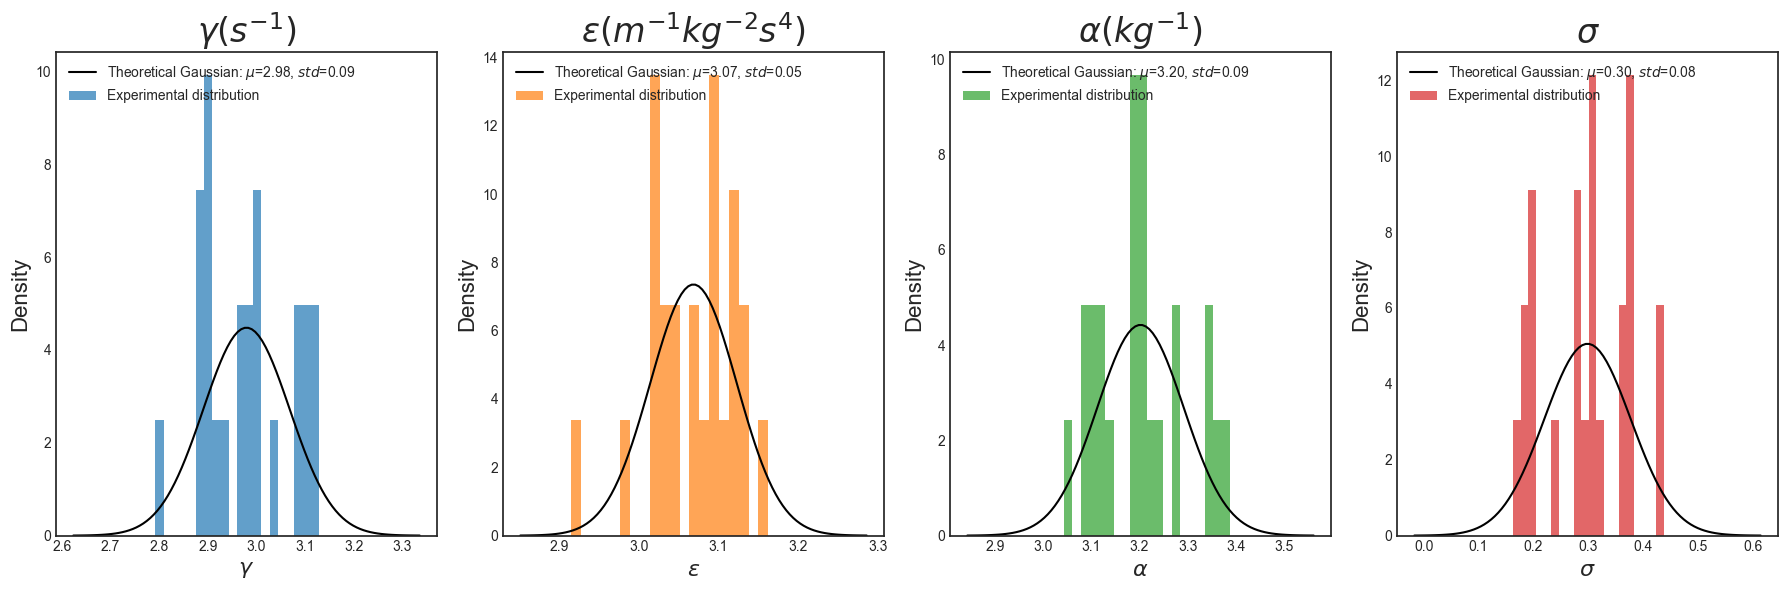

In [12]:
t_tests2 = []
sw_tests2 = []
means2 = []
devs2 = [] 

for subject in range(25, 37):
#subject = 25
    t_tests_, sw_tests_, means_, devs_ = plotting_dict_params(params_dict = params_loaded[subject], opt_sigma = opt_sigma[subject], 
                         barWidth=0.5, plotting_ = 1,
                         saving_plot = True, folder_name = 'fitted_pics', 
                         pic_name = f'parameters_gaussians_2{subject}')
    t_tests2.append(t_tests_)
    sw_tests2.append(sw_tests_)
    means2.append(means_)
    devs2.append(devs_)

#### Generating table for distributions

In [10]:
def generate_latex_table_by_subject(test_results, parameters, test_name):
    latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|" + "c|" * len(parameters) + "}\n\\hline\n"
    
    # Add headers
    latex_table += "Subject & " + " & ".join(parameters) + " \\\\\n\\hline\n"
    
    # Add data rows
    for subject, subject_results in test_results.items():
        values = [f"$\\mathcal{{N}}({result['mean']:.4f}, {result['std']:.4f})$" for result in subject_results]
        latex_table += f"{subject} & " + " & ".join(values) + " \\\\\n\\hline\n"
        
    latex_table += "\\end{tabular}\n\\caption{Means and deviations for " + test_name + " test for each parameter for each subject}\n\\label{tab:means_devs_" + test_name.lower().replace(' ', '_') + "}\n\\end{table}"
    
    return latex_table


In [14]:
test_results2 = {}
for subject, subject_means, subject_devs in zip(range(25, 37), means2, devs2):
    subject_results = [{'mean': mean, 'std': std} for mean, std in zip(subject_means, subject_devs)]
    test_results2[subject] = subject_results
   
parameters = ["$\gamma (s^{-1})$", "$\\varepsilon (m^3 kg^2 s^{-4})$", "$\\alpha (kg^{-1})$", "$\sigma$"]

# Generate the LaTeX table
test_name = "Shapiro-Wilk test"
latex_table = generate_latex_table_by_subject(test_results2, parameters, test_name)
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Subject & $\gamma (s^{-1})$ & $\varepsilon (m^3 kg^2 s^{-4})$ & $\alpha (kg^{-1})$ & $\sigma$ \\
\hline
25 & $\mathcal{N}(3.0093, 0.0992)$ & $\mathcal{N}(3.0772, 0.0487)$ & $\mathcal{N}(3.1943, 0.0624)$ & $\mathcal{N}(0.3357, 0.0798)$ \\
\hline
26 & $\mathcal{N}(2.9972, 0.0758)$ & $\mathcal{N}(3.0775, 0.0326)$ & $\mathcal{N}(3.2099, 0.0546)$ & $\mathcal{N}(0.3025, 0.0718)$ \\
\hline
27 & $\mathcal{N}(2.9711, 0.0337)$ & $\mathcal{N}(3.0609, 0.0429)$ & $\mathcal{N}(3.2132, 0.1152)$ & $\mathcal{N}(0.3252, 0.0866)$ \\
\hline
28 & $\mathcal{N}(3.0309, 0.0873)$ & $\mathcal{N}(3.0867, 0.0444)$ & $\mathcal{N}(3.1814, 0.0930)$ & $\mathcal{N}(0.3017, 0.0824)$ \\
\hline
29 & $\mathcal{N}(2.9607, 0.0275)$ & $\mathcal{N}(3.0604, 0.0258)$ & $\mathcal{N}(3.2240, 0.0374)$ & $\mathcal{N}(0.3397, 0.0715)$ \\
\hline
30 & $\mathcal{N}(2.9750, 0.0842)$ & $\mathcal{N}(3.0594, 0.0488)$ & $\mathcal{N}(3.1907, 0.0757)$ & $\mathcal{N}(0.2935, 0.104

In [24]:
means[-1]

[2.9795840902653032,
 3.0686286954570376,
 3.2019438198266204,
 5.9731735160413875]

In [22]:
def generate_latex_table(test_results, parameters, test_name):
    latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|" + "c|" * len(parameters) + "}\n\\hline\n"
    
    latex_table += "Motivation & " + " & ".join(parameters) + " \\\\\n\\hline\n"
    
    # Add data rows
    for subject, subject_results in enumerate(test_results, start=25):
        pvalues = [f"{result.pvalue:.2e}" for result in subject_results]
        latex_table += f"{subject} & " + " & ".join(pvalues) + " \\\\\n"
        
    latex_table += "\\hline\n\\end{tabular}\n\\caption{P-values for " + test_name + " test for each parameter for each subject}\n\\label{tab:pvalues_" + test_name.lower().replace(' ', '_') + "}\n\\end{table}"
    
    return latex_table

In [23]:
# Parameters and headers
parameters = ["$\gamma (s^{-1})$", "$\varepsilon (m^3 kg^2 s^{-4})$", "$\alpha (kg^{-1})$", "$\sigma$"]

# Generate LaTeX code for T-test table
latex_ttest_table = generate_latex_table(t_tests, parameters, parameters, "T-test")

# Generate LaTeX code for Shapiro-Wilk test table
latex_swtest_table = generate_latex_table(sw_tests, parameters, parameters, "Shapiro-Wilk")


In [25]:
# Print the LaTeX code
print(latex_ttest_table)


\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Subject & $\gamma (s^{-1})$ & $arepsilon (m^3 kg^2 s^{-4})$ & $lpha (kg^{-1})$ & $\sigma$ \\
\hline
25 & 2.07e-07 & 8.79e-02 & 2.97e-03 & 5.07e-53 \\
26 & 1.04e-03 & 7.33e-01 & 3.25e-02 & 7.03e-48 \\
27 & 7.17e-01 & 2.36e-01 & 1.11e-10 & 5.76e-39 \\
28 & 6.38e-06 & 1.69e-01 & 2.35e-07 & 6.83e-43 \\
29 & 9.05e-01 & 8.61e-01 & 4.05e-01 & 1.19e-48 \\
30 & 2.89e-05 & 8.87e-02 & 6.69e-05 & 7.12e-32 \\
31 & 7.05e-01 & 8.43e-01 & 1.39e-01 & 1.32e-38 \\
32 & 1.82e-04 & 1.06e-02 & 5.67e-06 & 4.28e-56 \\
33 & 2.60e-04 & 6.36e-01 & 2.10e-03 & 2.11e-45 \\
34 & 4.76e-05 & 3.62e-01 & 1.93e-03 & 5.01e-39 \\
35 & 1.79e-04 & 2.28e-01 & 3.04e-05 & 1.11e-47 \\
36 & 6.59e-06 & 3.21e-02 & 5.69e-07 & 3.10e-39 \\
\hline
\end{tabular}
\caption{P-values for T-test test for each parameter for each subject}
\label{tab:pvalues_t-test}
\end{table}


In [26]:
print(latex_swtest_table)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Subject & $\gamma (s^{-1})$ & $arepsilon (m^3 kg^2 s^{-4})$ & $lpha (kg^{-1})$ & $\sigma$ \\
\hline
25 & 9.45e-03 & 7.16e-01 & 8.78e-01 & 1.23e-01 \\
26 & 1.15e-02 & 3.82e-01 & 3.96e-01 & 7.62e-01 \\
27 & 6.11e-01 & 5.11e-03 & 2.25e-07 & 3.05e-03 \\
28 & 3.08e-02 & 2.90e-02 & 7.49e-03 & 6.01e-01 \\
29 & 1.21e-01 & 2.03e-01 & 1.70e-01 & 7.60e-01 \\
30 & 5.48e-01 & 6.46e-03 & 2.35e-01 & 6.83e-02 \\
31 & 4.30e-01 & 6.71e-01 & 6.30e-01 & 1.95e-02 \\
32 & 2.37e-02 & 1.73e-02 & 1.16e-01 & 2.13e-01 \\
33 & 2.82e-03 & 7.09e-01 & 1.01e-01 & 4.32e-01 \\
34 & 9.98e-03 & 6.82e-01 & 2.85e-01 & 1.47e-01 \\
35 & 5.40e-02 & 9.98e-01 & 4.31e-01 & 9.48e-01 \\
36 & 1.83e-01 & 2.68e-01 & 4.29e-01 & 1.50e-01 \\
\hline
\end{tabular}
\caption{P-values for Shapiro-Wilk test for each parameter for each subject}
\label{tab:pvalues_shapiro-wilk}
\end{table}


### Fitting the parameters

In [29]:
import numpy as np
from scipy.stats import chi2, chisquare, kstest

# Example sigma parameters
sigma_params__ = np.random.chisquare(df=2, size=1000)  # Generating sample chi-squared data with df=2

# Calculate the degrees of freedom
df = 2  # Known for this example

# Chi-Squared Goodness-of-Fit Test
observed_freq, bins = np.histogram(sigma_params__, bins='auto', density=False)
expected_freq = chi2.pdf((bins[1:] + bins[:-1]) / 2, df=df) * np.diff(bins) * len(sigma_params__)

# Normalize observed and expected frequencies to sum to the same value
observed_freq = observed_freq / observed_freq.sum()
expected_freq = expected_freq / expected_freq.sum()

chi2_stat, chi2_p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

print(f"Chi-Squared Statistic: {chi2_stat:.4f}")
print(f"Chi-Squared P-value: {chi2_p_value:.4f}")

# Kolmogorov-Smirnov Test
ks_stat, ks_p_value = kstest(sigma_params__, 'chi2', args=(df,))

print(f"K-S Statistic: {ks_stat:.4f}")
print(f"K-S P-value: {ks_p_value:.4f}")


Chi-Squared Statistic: 0.0308
Chi-Squared P-value: 1.0000
K-S Statistic: 0.0229
K-S P-value: 0.6600


#### Loading fitted parameters

In [7]:
print(opt_sigma.keys())
print(opt_sigma[28].keys())
print(opt_sigma[28]['28_32_cluster_3'].x)
opt_sigma[28]['28_32_cluster_3']

dict_keys([25, 31, 36, 30, 29, 27, 26, 28, 35, 32, 33, 34])
dict_keys(['28_32_cluster_3', '28_12_cluster_1', '28_21_cluster_2', '28_21_cluster_3', '28_12_cluster_0', '28_32_cluster_2', '28_11_cluster_1', '28_31_cluster_3', '28_22_cluster_2', '28_22_cluster_3', '28_31_cluster_2', '28_11_cluster_0', '28_31_cluster_1', '28_11_cluster_3', '28_22_cluster_0', '28_22_cluster_1', '28_11_cluster_2', '28_31_cluster_0', '28_12_cluster_3', '28_32_cluster_1', '28_21_cluster_0', '28_21_cluster_1', '28_32_cluster_0', '28_12_cluster_2'])
5.07244087283925


 message: Solution found.
 success: True
  status: 0
     fun: 0.56
       x: 5.07244087283925
     nit: 36
    nfev: 36

## Functions

### Simulating trajectories

In [75]:
def generated_multiple_trajectories_plot_(scaled_data_dict: dict, params_loaded: dict, 
                            opt_sigma : dict, 
                            first_subj: int = 25, last_subj: int = 37,
                            n_clusters = 4,
                            saving = True, 
                            save_dir: str = 'subject_plots', 
                            picname: str = 'Simulated_trajectories'): 
    

    
    for subject in range(first_subj, last_subj):
        
        print('Simulated and experimental trajectories for subject ', subject )
        fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns of subplots
        fig.suptitle(f'Subject {subject} Simulated Trajectories', fontsize=16)
        subplot_index = 0
        pic_name = f'{picname}_{subject}'

        colors = ['r', 'g', 'b', 'c']
        
        for motivation in range(1, 4):
            
            for mode in range(1, 3):
                ax = axes[subplot_index // 2, subplot_index % 2]
                
                
                for cluster in range(n_clusters):
                    
                    key_x = f'dfx_{subject}_{motivation}{mode}_cluster_{cluster}'
                    key_y = f'dfy_{subject}_{motivation}{mode}_cluster_{cluster}'
                    key_ = f'{subject}_{motivation}{mode}_cluster_{cluster}' 

                    # Retrieve data if available
                    dfx_ = scaled_data_dict[subject].get(key_x)
                    dfy_ = scaled_data_dict[subject].get(key_y)
                    params = params_loaded[subject].get(key_)
                    sigma = opt_sigma[subject].get(key_)
                    
                    if params is not None and sigma is not None:
                        try:
                            x_, y_ = plot_multiple_trajectories(dfx_, dfy_, params, sigma, 
                                                                motivation = motivation, mode = mode,  
                                                                ax=ax, saving_plot=False, pic_name = pic_name,
                                                                color = colors[cluster])
                        except ValueError as e:
                            print(f"Skipping cluster {cluster} for subject {subject}, motivation {motivation}, mode {mode}: {e}")
                
                    
                    
                
                subplot_index += 1
                
        fig.tight_layout(rect=[0, 0, 1, 0.96])  
        
        if saving:
            # Check if the 'pics' folder exists, if not, create it
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            # Save the figure with a specific name based on the cluster
            filepath = os.path.join(save_dir, pic_name)
            plt.savefig(filepath)
            #plt.savefig(os.path.join(save_dir, pic_name))
        
        plt.close(fig)
        
    return x_, y_

def plot_multiple_trajectories(dfx: pd.DataFrame, dfy: pd.DataFrame,
                               new_params: np.ndarray, opt_Sigma: np.float64,  
                               motivation: int, mode : int, 
                               parameters2=(3.7, -0.15679707,  0.97252444,  0.54660283, -6.75775885, -0.06253371),
                               n=50, timestep=1/500, pic_name ='Simulated_Trajectories', 
                               ax=None, saving_plot=False, color = 'blue'): 
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ## Plotting experimental data
    for i in range(len(dfx)):
        ax.plot(dfx.iloc[i], dfy.iloc[i], color='gray', alpha=0.5)
        
    ## Plotting numerical simulation
    gamma, epsilon, alpha = new_params.x
    sigma = opt_Sigma.x
    
    for i in range(n):
        x, y, v, w, ux, uy, T = numericalSimulation(x_0=(0,0,0,0), p_T=1.3, 
                                                     sigma=sigma*0.05, gamma=gamma, epsilon=epsilon, alpha=alpha,
                                                     u_0=parameters2[:2], l_0=parameters2[2:], 
                                                     i_max=1000, dt=timestep,
                                                     Autoregr=False, 
                                                     Arc=True, angle=math.pi*12/24, angle0=0, p=(.2,0), r=.1)
        ax.plot(x, y, color = color) 
    
    x_, y_, v_, w_, ux_, uy_, T_ = numericalSimulation(x_0=(0,0,0,0), p_T=1.3, 
                                                       sigma=sigma * 0.05, gamma=gamma, epsilon=epsilon, alpha=alpha,
                                                       u_0=parameters2[:2], l_0=parameters2[2:], 
                                                       i_max=1000, dt=timestep,
                                                       Autoregr=False, 
                                                       Arc=True, angle=math.pi*12/24, angle0=0, p=(.2,0), r=.1)
    #plot_trajectory(x_, y_, ax=ax, showing=False)
    
    ax.set_title(f'Motivation {motivation}, Mode {mode}')
    #ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.legend()
    
    if saving_plot:
        # Check if the 'pics' folder exists, if not, create it
        if not os.path.exists('pics'):
            os.makedirs('pics')
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}{subject}.png'
        filepath = os.path.join('pics', filename)
        plt.savefig(filepath)
    
    if ax is None:
        plt.show()
        
    return x_, y_



### Linear transformation as default

In [38]:
import math 
from typing import Tuple, List, Dict

def linear_transf_(dfx : pd.DataFrame, dfy : pd.DataFrame, 
                  rectx : np.ndarray, recty : np.ndarray) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    if rectx[0] > 0 and recty[-1] > 0:
        model_target = np.array((0.5,1))
        screen_target = np.array(((rectx[1]+rectx[0])/2,(recty[1]+recty[0])/2))
        model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 

    elif rectx[0] < 0 and recty[-1] > 0: 
        model_target = np.array((1.5,0))
        dfx = -1 * dfx
        screen_target = np.array(((-rectx[1]-rectx[0])/2,(recty[1]+recty[0])/2))
        model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
        
    elif rectx[0] > 0 and recty[-1] < 0:
        model_target = np.array((1.5,0))
        dfy = -1 * dfy
        screen_target = np.array(((rectx[1]+rectx[0])/2,(-recty[1]-recty[0])/2)) 
        model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
        
    else: 
        model_target = np.array((0.5,1))
        dfx = -1 * dfx
        dfy = -1 * dfy
        screen_target = np.array(((-rectx[1]-rectx[0])/2,(-recty[1]-recty[0])/2))
        model_origin = np.array((np.cos(-math.pi*12/24),np.sin(-math.pi*12/24))) 
   
    screen_origin = np.array((0,0))

    v_model=model_target-model_origin
    v_model_ort=np.array((v_model[1],-v_model[0]))

    v_screen=screen_target-screen_origin
    v_screen_ort=np.array((v_screen[1],-v_screen[0]))

    model_M=np.vstack((np.append(model_origin,1),np.append(model_target,1),np.append(v_model_ort,0))).T
    screen_M=np.vstack((np.append(screen_origin,1),np.append(screen_target,1),np.append(v_screen_ort,0))).T

    M=np.dot(model_M,np.linalg.inv(screen_M))
    A=M[:2,:2]
    b=M[:2,-1:].flatten()
    
    dfx_=A[0,0]*dfx+A[0,1]*dfy+b[0]
    dfy_=A[1,0]*dfx+A[1,1]*dfy+b[1]
    
    return dfx_, dfy_

In [10]:
cleaned_data_dict, idxrule_dict = load_processed_mult_data(folder_name='clustered_multiple_data')
    

Loading the cleaned data...
CSV and idxrule JSON files have been loaded successfully.


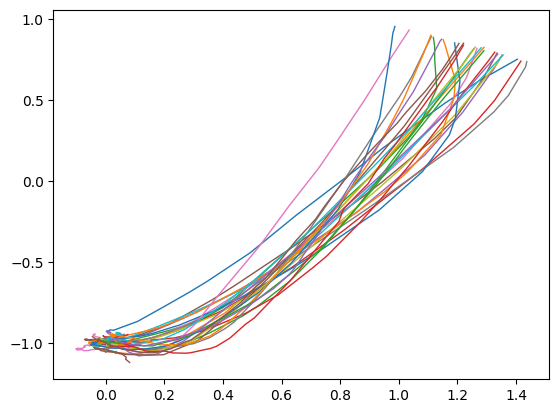

In [39]:
subject = 25
mode = 1
motivation = 1
cluster = 0
saving = False


dfx, dfy = get_cluster_data(cleaned_data_dict, subject, motivation, mode, cluster)
idxrule = get_cluster_idxrule(idxrule_dict, subject, motivation, mode, cluster)
dfx_, dfy_ = linear_transf(dfx, dfy, segments[cluster][0], segments[cluster][1])

for i in range(dfx.shape[0]):
    plt.plot(dfx_.iloc[i, :], dfy_.iloc[i, :], linestyle='-', linewidth=1, markersize=2,
            label=f'Cluster {cluster}' if i == 0 else "")
    

plt.show() 

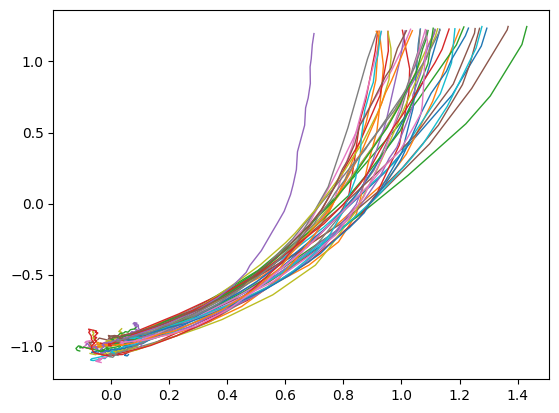

In [40]:
subject = 25
mode = 1
motivation = 1
cluster = 2
saving = False


dfx, dfy = get_cluster_data(cleaned_data_dict, subject, motivation, mode, cluster)
idxrule = get_cluster_idxrule(idxrule_dict, subject, motivation, mode, cluster)
dfx_, dfy_ = linear_transf(dfx, dfy, segments[cluster][0], segments[cluster][1])

for i in range(dfx.shape[0]):
    plt.plot(dfx_.iloc[i, :], dfy_.iloc[i, :], linestyle='-', linewidth=1, markersize=2,
            label=f'Cluster {cluster}' if i == 0 else "")
    

plt.show()

In [8]:

def get_cluster_data(cleaned_data_dict, subject, motivation, mode, cluster):
    cluster_key_x = f'dfx_{subject}_{motivation}{mode}_cluster_{cluster}'
    cluster_key_y = f'dfy_{subject}_{motivation}{mode}_cluster_{cluster}'
    
    if subject in cleaned_data_dict:
        subject_data = cleaned_data_dict[subject]
        if cluster_key_x in subject_data and cluster_key_y in subject_data:
            dfx = subject_data[cluster_key_x]
            dfy = subject_data[cluster_key_y]
            return dfx, dfy
        else:
            raise ValueError(f"Cluster {cluster} not found for subject {subject} with motivation {motivation} and mode {mode}.")
    else:
        raise ValueError(f"Subject {subject} not found in the dataset.")

def get_cluster_idxrule(idxrule_dict, subject, motivation, mode, cluster):
    idxrule_key = f'dfx_{subject}_{motivation}{mode}_cluster_{cluster}'
    res_key = f'{subject}_{motivation}{mode}_cluster_{cluster}'
   
    if subject in idxrule_dict:
        subject_idxrules = idxrule_dict[subject]
        if idxrule_key in subject_idxrules:
            idxrule = subject_idxrules[idxrule_key]
            return idxrule
        elif res_key in subject_idxrules:
            idxrule = subject_idxrules[res_key]
            return idxrule
        else:
            raise ValueError(f"Index rule for cluster {cluster} not found for subject {subject} with motivation {motivation} and mode {mode}.")
    else:
        raise ValueError(f"Subject {subject} not found in the idxrule dataset.")
    

### Statistical Tests for Gaussianity

**Shapiro-Wilk Test**: the Shapiro-Wilk test (`scipy.stats.shapiro`) can be used to test each parameter's distribution for normality.
- Null hypothesis (H0): The distribution is normal.
- Alternative hypothesis (H1): The distribution is not normal.

**P-value Interpretation**: For each parameter, interpret the Shapiro-Wilk test's p-value:
- If p-value > 0.05, accept the null hypothesis (distribution is likely normal).
- If p-value <= 0.05, reject the null hypothesis (distribution is not normal).


In [107]:
from scipy.stats import norm, shapiro

# Statistical tests for Gaussianity (Shapiro-Wilk test)
def test_gaussianity(parameters: np.ndarray):
    num_params = parameters.shape[1]  # Number of parameters (should be 4)
    p_values = []

    print('Shapiro-Wilk Test Results:')
    for i in range(num_params):
        param_values = parameters[:, i]
        _, p_value = shapiro(param_values)
        p_values.append(p_value)
        print(f'Parameter {i+1}: p-value = {p_value:.4f}')

    return p_values

In [108]:
# Perform statistical tests
p_values = test_gaussianity(combined_params)


Shapiro-Wilk Test Results:
Parameter 1: p-value = 0.0000
Parameter 2: p-value = 0.0000
Parameter 3: p-value = 0.0000
Parameter 4: p-value = 0.0000


In [15]:
def generate_latex_table(t_tests, sw_tests, subject):
    headers = ["Parameter", "T-test p-value", "Shapiro-Wilk p-value"]
    parameters = ["$\gamma (s^{-1})$", "$\varepsilon (m^3 kg^2 s^{-4})$", "$\alpha (kg^{-1})$", "$\sigma$"]
    
    latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n"
    
    # Add headers
    latex_table += " & ".join(headers) + " \\\\\n\\hline\n"
    
    # Add data rows
    for i in range(len(parameters)):
        t_pvalue = t_tests[i].pvalue
        sw_pvalue = sw_tests[i].pvalue
        latex_table += f"{parameters[i]} & {t_pvalue:.2e} & {sw_pvalue:.2e} \\\\\n"
        
    latex_table += "\\hline\n\\end{tabular}\n\\caption{P-values for T-test and Shapiro-Wilk test for each parameter for subject "
    latex_table += f"{subject}"
    latex_table += "}\n\\label{tab:pvalues}\n\\end{table}"
    
    return latex_table
